In [1]:
import numpy as np
import pandas as pd
import torch
import random
import sys
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import copy
from os import listdir
import glob
import xarray as xr
import yaml
from datetime import datetime, timedelta
import pickle
from pathlib import Path
import re 

In [11]:
base_dir = os.getcwd().rsplit('/',1)[0]
sys.path.append(base_dir + '/neuralhydrology-pilstm')

from neuralhydrology.evaluation.metrics import nse, pearsonr, beta_kge, fdc_fhv, fdc_fms, fdc_flv
from neuralhydrology.datautils.QS_physical_model import QS_physical_model

In [3]:
torch.manual_seed(22)
sns.set_style("white")
sns.set_context("talk", font_scale = 1)
plt.rcParams.update({'figure.max_open_warning': 0})

# Evaluate the results

In [4]:
data_record_length_d = {}
data_record_length_d['drycreek'] = ['01/10/2006', '30/09/2017']
data_record_length_d['hjandrews'] = ['01/10/2006', '30/09/2017']
data_record_length_d['harvardforest'] = ['01/01/2009', '31/12/2019']
data_record_length_d['hubbardbrook'] = ['01/01/1999', '31/12/2009']
data_record_length_d['jornadabasin'] = ['01/01/2001', '31/12/2011']
data_record_length_d['kellogg'] = ['01/01/2008', '31/12/2018']
data_record_length_d['konzaprairie'] = ['01/10/2009', '30/09/2020']
data_record_length_d['sevilleta'] = ['01/01/2009', '31/12/2019']

watersheds = list(data_record_length_d.keys())

data_record_length_d

{'drycreek': ['01/10/2006', '30/09/2017'],
 'hjandrews': ['01/10/2006', '30/09/2017'],
 'harvardforest': ['01/01/2009', '31/12/2019'],
 'hubbardbrook': ['01/01/1999', '31/12/2009'],
 'jornadabasin': ['01/01/2001', '31/12/2011'],
 'kellogg': ['01/01/2008', '31/12/2018'],
 'konzaprairie': ['01/10/2009', '30/09/2020'],
 'sevilleta': ['01/01/2009', '31/12/2019']}

In [5]:
# Create a dataframe to store the model evaluation results
exps = ['LSTM_AT_PPT', 'LSTM_ET_PPT']
exp_names_d = {'LSTM_AT_PPT':'LSTM\n(PPT,AT)', 'LSTM_ET_PPT':'LSTM\n(PPT,PET)', 
               'PILSTM_PPT_ET_1out':'PILSTM\n(PPT,PET)', 'PILSTM_PPT_AT_1out':'PILSTM\n(PPT,AT)'}


In [6]:
forcings_d = {'DryCreek': ['TL_Precipitation', 'TL_Evapotranspiration', 'TL_AirTemperature'],
                      'HJAndrews': ['PRIMET_Precipitation', 'PRIMET_Evapotranspiration', 'PRIMET_AirTemperature'],
                      'HarvardForest': ['HF001_Precipitation','HF001_Evapotranspiration', 'HF001_AirTemperature'],
                      'HubbardBrook': ['WS7_Precipitation', 'STAHQ_Evapotranspiration','STAHQ_AirTemperature'],
                      'JornadaBasin': ['JWSTA_Precipitation','JWSTA_Evapotranspiration','JWSTA_AirTemperature'],
                      'Kellogg': ['KBS002_Precipitation',  'KBS002_Evapotranspiration', 'KBS002_AirTemperature'],
                      'KonzaPrairie': ['HQ01_Precipitation', 'HQ01_Evapotranspiration','HQ01_AirTemperature'],
                      'Sevilleta': ['Station44_Precipitation', 'Station44_Evapotranspiration','Station44_AirTemperature']}

discharge_d = { 'DryCreek': ['LG_Discharge'],
                        'HJAndrews': ['GSLOOK_Discharge'],
                        'HarvardForest': ['BigelowLower_Discharge'],
                        'HubbardBrook': ['WS7_Discharge'],
                        'JornadaBasin': ['SaltCreek_Discharge'],
                        'Kellogg': ['KBS096_Discharge'],
                        'KonzaPrairie':['KingsCreek_Discharge'],
                        'Sevilleta':['Bernado_Discharge']}

In [7]:
def physical_model_performance_base_experiment(
    watershed,
    yaml_file_path,
    data_path):

    # get data for this watershed
    data = pd.read_csv(f'{data_path}/{watershed}_12yrs_ET.csv', index_col = 'DateTime',  parse_dates=True)
    
    # get train and test dates from yml file
    with open(yaml_file_path, 'r') as file:
        yaml_content = yaml.safe_load(file)
        train_start_dates, train_end_dates = yaml_content['train_start_date'], yaml_content['train_end_date']
        test_start_date = datetime.strptime(yaml_content['test_start_date'], '%d/%m/%Y')
        test_end_date = datetime.strptime(yaml_content['test_end_date'], '%d/%m/%Y')
        
    if not isinstance(train_start_dates, list):
        train_start_dates = [train_start_dates]
    if not isinstance(train_end_dates, list):
        train_end_dates = [train_end_dates]
    
    train_start_dates = [datetime.strptime(train_start_date, '%d/%m/%Y') for train_start_date in train_start_dates]
    train_end_dates = [datetime.strptime(train_end_date, '%d/%m/%Y') for train_end_date in train_end_dates]
    
    train_date_pairs = zip(train_start_dates, train_end_dates)
    train_date_array = np.array([start + timedelta(days=x) for start, end in train_date_pairs for x in range((end - start).days + 1)])
    test_date_array = [test_start_date + timedelta(days=x) for x in range((test_end_date - test_start_date).days + 1)]
    
    print('train_start_dates are', train_start_dates)
    print('train_end_dates are', train_end_dates)
    # get par file
    par_file_name = f"{watershed}_QSmodel_parameters_searching"
    
    for train_start_date, train_end_date in zip(train_start_dates, train_end_dates):    
        #train_start_date = datetime.strptime(train_start_date, '%d/%m/%Y')
        train_start_date = train_start_date.strftime('%Y-%m-%d')
    
        #train_end_date = datetime.strptime(train_end_date, '%d/%m/%Y')
        train_end_date = train_end_date.strftime('%Y-%m-%d')
        
        par_file_name += f"_{train_start_date}"
        par_file_name += f"_{train_end_date}"
    
    par_file_name += ".csv"
    print('par_file_name is', par_file_name)
    
    par_file_path = f"{dir_path}/calibration_results/{par_file_name}"
    QS_par_results = pd.read_csv(par_file_path, index_col=0)
    
    # get the basin data
    data = data.loc[:, forcings_d[watershed]+discharge_d[watershed]]
        
    new_col_names = []
    for col in data.columns:
        if 'precipitation' in col.lower():
            new_col_names.append('PRCP(mm/day)')
        elif 'evapotranspiration' in col.lower():
            new_col_names.append('PET(mm/day)')
        elif 'airtemperature' in col.lower():
            new_col_names.append('Tavg(C)')
        elif 'discharge' in col.lower():
            new_col_names.append('QObs(mm/d)')
        else:
            raise RuntimeError(f"Forcing type is not recognized")
    data.columns = new_col_names
        
    physical_model = QS_physical_model(basin = watershed,
                                           catchment_data = data, 
                                           train_start_dates = train_start_dates,
                                           train_end_dates = train_end_dates,
                                           timestep = 24,
                                           save_path = par_file_path.rsplit('/',1)[0], # so the model can directly read parameters from the file
                                           init_sample_n = 500,
                                           opt_iter_n = 15000,
                                           sample_n_acq = 5000,
                                           sample_n_score_calculated = 10)
    
    test_df = data.loc[test_date_array,:]
    test_df['Q_pred'] = np.array(physical_model.integrate_Q(df = test_df))
    
    Q_obs = xr.DataArray(test_df['QObs(mm/d)'].values)
    Q_pred = xr.DataArray(test_df['Q_pred'].values)
        
    res_d = {'model':'Physical',
                        'watershed':watershed, 
                        'NSE':round(nse(Q_obs, Q_pred), 2),  
                        'r':round(pearsonr(Q_obs, Q_pred), 2), 
                        'Bias':round(beta_kge(Q_obs, Q_pred), 2), 
                        'FHV':round(fdc_fhv(Q_obs, Q_pred), 2), 
                        'FMS':round(fdc_fms(Q_obs, Q_pred), 2), 
                        'FLV':round(fdc_flv(Q_obs, Q_pred), 2)
                       } 
    return res_d

In [8]:
def DOY_performance(watershed = 'DryCreek',
    yaml_file_path = '/Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/runs/data_scarce/lstm_531_PPT_AT_finetune_drycreek_None_2006-10-0100_00_00_2012-09-3000_00_00_1711_015254/config.yml', 
    data_path = '/Users/angelikazhang/Desktop/PILSTM/chosen/'):  
    
    with open(yaml_file_path, 'r') as file:
        yaml_content = yaml.safe_load(file)
        train_start_dates, train_end_dates = yaml_content['train_start_date'], yaml_content['train_end_date']
        test_start_date =datetime.strptime(yaml_content['test_start_date'], '%d/%m/%Y')
        test_end_date = datetime.strptime(yaml_content['test_end_date'], '%d/%m/%Y')
     
    # read data
    df = pd.read_csv(f'{data_path}/{watershed}_12yrs_ET.csv', index_col = 'DateTime',  parse_dates=True)
    
    # get train and test dates
    if not isinstance(train_start_dates, list):
        train_start_dates = [train_start_dates]
    if not isinstance(train_end_dates, list):
        train_end_dates = [train_end_dates]
    
    train_start_dates = [datetime.strptime(train_start_date, '%d/%m/%Y') for train_start_date in train_start_dates]
    train_end_dates = [datetime.strptime(train_end_date, '%d/%m/%Y') for train_end_date in train_end_dates]
    
    train_date_pairs = zip(train_start_dates, train_end_dates)
    train_date_array = np.array([start + timedelta(days=x) for start, end in train_date_pairs for x in range((end - start).days + 1)])
    test_date_array = [test_start_date + timedelta(days=x) for x in range((test_end_date - test_start_date).days + 1)]
    
    # get train df
    train_df = df.loc[train_date_array]
    test_df = df.loc[test_date_array]

    Q_col = discharge_d[watershed]
    DOY_stat = train_df[Q_col].groupby(train_df.index.strftime('%m%d')).mean()

    Q_pred = xr.DataArray(DOY_stat.loc[test_df.index.strftime('%m%d'),:].values.reshape(-1))
    Q_obs = xr.DataArray(test_df[Q_col].values.reshape(-1))
    #print(Q_pred.shape)
    #print(Q_obs.shape)
    
    res_d = {'model':'DOY',
                        'watershed':watershed, 
                        'NSE':round(nse(Q_obs, Q_pred), 2),  
                        'r':round(pearsonr(Q_obs, Q_pred), 2), 
                        'Bias':round(beta_kge(Q_obs, Q_pred), 2), 
                        'FHV':round(fdc_fhv(Q_obs, Q_pred), 2), 
                        'FMS':round(fdc_fms(Q_obs, Q_pred), 2), 
                        'FLV':round(fdc_flv(Q_obs, Q_pred), 2)
                       }
    
    return  res_d

In [9]:
def get_training_years(input_string = "lstm_531_PPT_AT_finetune_drycreek_None_2006-10-0100_00_00_2012-09-3000_00_00_1611_220123"):

    # Define a pattern for extracting dates in the format DD_MM_YYYY
    date_pattern = re.compile(r'(\d{4}-\d{2}-\d{2})')

    # Find all matches in the string
    matches = date_pattern.findall(input_string)

    # Extract start and end dates if available
    if len(matches) >= 2:
        start_date_str, end_date_str = matches[:2]

        # Convert strings to datetime objects
        start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
        end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

        #print("Start Date:", start_date)
        #print("End Date:", end_date)

        # Calculate the duration in years (as an integer)
        total_days = (end_date - start_date).days+1
        years, remainder = divmod(total_days, 365)

        #print("Duration (in years):", int(years))
    #else:
        #print("Unable to extract start and end dates.")
    
    return years

# 1. Base experiment results

In [14]:
watersheds = ['DryCreek','HJAndrews','HarvardForest','HubbardBrook',
              'JornadaBasin','Kellogg','KonzaPrairie','Sevilleta']

dir_path = f'{base_dir}/experiments'
data_path = f'{base_dir}/chosen_data'

In [15]:
# get physical model performance for base experiment
res = []
exp = 'PILSTM_PPT_ET_1out' # does not matter which exp
exp_lower = exp.lower()

for watershed in watersheds[:]:
    print('\n', watershed)
    watershed_lower = watershed.lower()
    
    # get base_experiment yml file
    yml_file_path = f"{base_dir}/experiments/{exp}/configs/finetune_{watershed_lower}_{exp_lower}.yml"
    res_d = physical_model_performance_base_experiment(watershed = watershed,
                                                       yaml_file_path = yml_file_path,
                                                       data_path = data_path)
    res.append(res_d)
    
phy_res_df = pd.DataFrame(res)
phy_res_df


 DryCreek
train_start_dates are [datetime.datetime(2006, 10, 1, 0, 0)]
train_end_dates are [datetime.datetime(2012, 9, 30, 0, 0)]
par_file_name is DryCreek_QSmodel_parameters_searching_2006-10-01_2012-09-30.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-3.690789930518239, -1.6969452835164736], 'c2': [-1.2527739013477874, 2.1314485513585972], 'c3': [-0.628539887166357, 1.0998933693024273], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is DryCreek_QSmodel_parameters_searching_2006-10-01_2012-09-30.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-3.6591405355656828, -3.605393125660433), 'c2': (0.5561255493292195, 0.7815762010521373), 'c3': (-0.35618499580840723, -0.2518304580380263), 'runoff_coef': (0.3758245363762044, 0.3867953935185533)}
Reach maximum iterations! Stop optimizatio


 Sevilleta
train_start_dates are [datetime.datetime(2009, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2014, 12, 31, 0, 0)]
par_file_name is Sevilleta_QSmodel_parameters_searching_2009-01-01_2014-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-2.293354970284998, 0.42926912461074906], 'c2': [-1.5042182863541764, 0.6545858705977634], 'c3': [-0.2491494981419906, 0.10323741410262753], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is Sevilleta_QSmodel_parameters_searching_2009-01-01_2014-12-31.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-1.4177202896560164, -1.302321315552651), 'c2': (-0.640478758426799, -0.5558681872978559), 'c3': (-0.2491268284940083, -0.2326684453480149), 'runoff_coef': (0.17362107360183363, 0.1815022246037898)}
Reach maximum iterations! Stop optim

model      watershed   NSE     r  Bias    FHV    FMS           FLV
0  Physical       DryCreek  0.69  0.87  0.74 -28.60   2.96  9.581000e+01
1  Physical      HJAndrews  0.67  0.85  1.08  17.32  -7.17  3.438000e+01
2  Physical  HarvardForest  0.22  0.55  1.11 -20.24 -13.06  8.233000e+01
3  Physical   HubbardBrook  0.03  0.21  1.01 -60.13 -50.35  7.200000e+01
4  Physical   JornadaBasin -0.17  0.15  2.60 -40.98 -51.47  8.055000e+01
5  Physical        Kellogg  0.17  0.62  1.03   0.08   2.42 -5.617000e+01
6  Physical   KonzaPrairie  0.07  0.27  0.72 -74.01 -82.38 -2.853874e+11
7  Physical      Sevilleta  0.19  0.56  0.89 -74.58 -84.10 -1.359540e+11

## Without pretraining

In [11]:
def get_base_exp_result(scenario = 'base_nopretrain',
                        dir_path = f'{base_dir}/neuralhydrology-pilstm/experiments'):
    
    exps = [ 'LSTM_ET_PPT', 'LSTM_AT_PPT', 'PILSTM_PPT_AT_1out', 'PILSTM_PPT_ET_1out'] # ,

    exp_name_d = {'LSTM_AT_PPT':'LSTM(PPT,AT)',
                  'LSTM_ET_PPT':'LSTM(PPT,PET)',
                  'PILSTM_PPT_AT_1out': 'PILSTM(PPT,AT)',
                  'PILSTM_PPT_ET_1out': 'PILSTM(PPT,PET)'}

    res_df = pd.DataFrame()

    for watershed in watersheds[:]:
        watershed_lower = watershed.lower()

        for exp in exps:
            #print(exp)
            if 'PILSTM' in exp:
                Q_col = 'Qpilstm(mm/d)'
            else:
                Q_col = 'QObs(mm/d)'

            eval_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_eval_result.csv',index_col=0)
           # display(eval_df.head())
            # eval_df = eval_df[['dry_wet_index', 'watershed', f'{Q_col}_NSE', 'lambda', 'seed','optimal_epoch']]

            valid_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_validation_result.csv',index_col=0)
           # display(valid_df.head())

            # find the optimal epoch and lambda for each dry_wet_index, each seed
            valid_df_optimal = valid_df.loc[valid_df.groupby(['seed'])['NSE'].idxmax()][['watershed','seed', 'lambda', 'epoch']]
            #display(valid_df_optimal.head())

            eval_df_optimal = pd.merge(eval_df, valid_df_optimal, on=['watershed','seed', 'lambda'], how='inner')
            eval_df_optimal.rename(columns = {f'{Q_col}_NSE':'NSE',
                                             f'{Q_col}_MSE':'MSE',
                                              f'{Q_col}_Pearson-r':'r',
                                              f'{Q_col}_Beta-KGE':'Bias',
                                             f'{Q_col}_FHV':'FHV',
                                             f'{Q_col}_FMS':'FMS',
                                             f'{Q_col}_FLV':'FLV'},
                                   inplace = True)

            eval_df_optimal = eval_df_optimal.groupby(['watershed']).mean(numeric_only=True)

            eval_df_optimal['watershed'] = watershed
            eval_df_optimal['model'] = exp_name_d[exp]

            #display(eval_df_optimal.head())

            res_df = pd.concat([res_df, eval_df_optimal], ignore_index=True)

    exp_res_df = copy.deepcopy(res_df)
    exp_res_df = exp_res_df[['model', 'watershed','lambda',  'NSE',
           'FHV', 'FMS', 'FLV', 'r',  'Bias']]  

    res_df_all = pd.concat([exp_res_df, phy_res_df], axis = 0)
    #res_df_all = pd.concat([res_df_all, doy_res_df], axis = 0)
    res_df_all.sort_values(by=['model','watershed'],inplace = True)
    res_df_all.reset_index(drop=True,inplace = True)
    res_df_all_base_nopretrain = copy.deepcopy(res_df_all)
    
    return res_df_all

In [12]:
def get_base_exp_result_new(scenario = 'base_nopretrain',
                           dir_path = f'{base_dir}/neuralhydrology-pilstm/experiments'):
    
    exps = [ 'LSTM_ET_PPT', 'LSTM_AT_PPT', 'PILSTM_PPT_AT_1out', 'PILSTM_PPT_ET_1out'] # ,

    exp_name_d = {'LSTM_AT_PPT':'LSTM(PPT,AT)',
                  'LSTM_ET_PPT':'LSTM(PPT,PET)',
                  'PILSTM_PPT_AT_1out': 'PILSTM(PPT,AT)',
                  'PILSTM_PPT_ET_1out': 'PILSTM(PPT,PET)'}

    res_df = pd.DataFrame()

    for watershed in watersheds[:]:
        watershed_lower = watershed.lower()

        for exp in exps:
            #print(exp)
            if 'PILSTM' in exp:
                eval_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}_new/{exp}_{scenario}_new_{watershed_lower}_eval_result.csv',index_col=0)
                valid_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}_new/{exp}_{scenario}_new_{watershed_lower}_validation_result.csv',index_col=0)

                # find the optimal epoch and lambda for each dry_wet_index, each seed
                valid_df_optimal = valid_df.loc[valid_df.groupby(['seed'])['NSE'].idxmax()][['watershed','seed', 'lambda', 'epoch']]
                #display(valid_df_optimal.head())

                eval_df_optimal = pd.merge(eval_df, valid_df_optimal, on=['watershed','seed', 'lambda'], how='inner')
                eval_df_optimal.rename(columns = {f'NSE':'NSE',
                                                 f'MSE':'MSE',
                                                  f'Pearson-r':'r',
                                                  f'Beta-KGE':'Bias',
                                                 f'FHV':'FHV',
                                                 f'FMS':'FMS',
                                                 f'FLV':'FLV'},
                                       inplace = True)
            else:
                Q_col = 'QObs(mm/d)'
                eval_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_eval_result.csv',index_col=0)
                valid_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_validation_result.csv',index_col=0)
        
                # find the optimal epoch and lambda for each dry_wet_index, each seed
                valid_df_optimal = valid_df.loc[valid_df.groupby(['seed'])['NSE'].idxmax()][['watershed','seed', 'lambda', 'epoch']]
                #display(valid_df_optimal.head())

                eval_df_optimal = pd.merge(eval_df, valid_df_optimal, on=['watershed','seed', 'lambda'], how='inner')
                eval_df_optimal.rename(columns = {f'{Q_col}_NSE':'NSE',
                                                 f'{Q_col}_MSE':'MSE',
                                                  f'{Q_col}_Pearson-r':'r',
                                                  f'{Q_col}_Beta-KGE':'Bias',
                                                 f'{Q_col}_FHV':'FHV',
                                                 f'{Q_col}_FMS':'FMS',
                                                 f'{Q_col}_FLV':'FLV'},
                                       inplace = True)

            eval_df_optimal = eval_df_optimal.groupby(['watershed']).mean(numeric_only=True)

            eval_df_optimal['watershed'] = watershed
            eval_df_optimal['model'] = exp_name_d[exp]

            #display(eval_df_optimal.head())

            res_df = pd.concat([res_df, eval_df_optimal], ignore_index=True)

    exp_res_df = copy.deepcopy(res_df)
    exp_res_df = exp_res_df[['model', 'watershed','lambda',  'NSE',
           'FHV', 'FMS', 'FLV', 'r',  'Bias']]  

    res_df_all = pd.concat([exp_res_df, phy_res_df], axis = 0)
    #res_df_all = pd.concat([res_df_all, doy_res_df], axis = 0)
    res_df_all.sort_values(by=['model','watershed'],inplace = True)
    res_df_all.reset_index(drop=True,inplace = True)
    res_df_all_base_nopretrain = copy.deepcopy(res_df_all)
    
    return res_df_all

In [13]:
def get_base_exp_nse_table(res_df_all):
    res_df_all_nse = res_df_all[['model','watershed','NSE']]
    res_df_all_nse_pivot = res_df_all_nse.pivot(index = 'watershed', columns = 'model', values = 'NSE')

    res_df_all_nse_pivot = res_df_all_nse_pivot[['LSTM(PPT,AT)', 'LSTM(PPT,PET)',
                                                 'PILSTM(PPT,AT)',
                                                 'PILSTM(PPT,PET)',
                                                 'Physical']]
                                                 #'DOY']]
    res_df_all_nse_pivot = res_df_all_nse_pivot.round(2)
    return res_df_all_nse_pivot

In [14]:
def plot_base_exp(df, pretrain = False):
    sns.set_style("white")
    sns.set_context("talk", font_scale = 1.3)

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
    char_lst = ['A', 'B', 'C', 'D', 'E', 'F']


    for i, metric in enumerate(['NSE', 'r', 'Bias', 'FHV', 'FMS', 'FLV']):
        #print(i)
        ax = axes.reshape(-1)[i]

        # Get unique models and assign colors
        unique_models = ['LSTM(PPT,AT)', 'LSTM(PPT,PET)', 'PILSTM(PPT,AT)',
           'PILSTM(PPT,PET)', 'Physical']#,'DOY']

        #colors = plt.cm.viridis(np.linspace(0, 1, len(unique_models)))
        # Set the Seaborn color palette to a categorical palette
        #colors = plt.cm.get_cmap('Dark2', len(df['model'].unique()))(np.arange(len(df['model'].unique())))
        colors = sns.color_palette('tab10')

        # Create a boxplot on the specified axis with custom colors
        boxplot = ax.boxplot(
            [df[df['model'] == model][metric] for model in unique_models],
            positions=np.arange(len(unique_models))/2,
            labels=unique_models,
            patch_artist=True,  widths=0.4,
            medianprops={'color': 'black'} # Enable color customization
        )

        # Customize boxplot colors
        for patch, color in zip(boxplot['boxes'], colors):
            patch.set_facecolor(color)

        # add hlines
        if i>2:
            ax.axhline(0, color='royalblue',alpha=0.5) 
        elif i<=1:
            ax.axhline(0, color='royalblue',alpha=0.5)
            ax.axhline(0.5, color='royalblue',alpha=0.5)
            ax.axhline(1, color='royalblue',alpha=0.5)
        elif i==2:
            ax.axhline(1, color='royalblue',alpha=0.5)
        

        # Set labels and title
        ax.set_ylabel('')
        ax.set_xlabel('')

        if i<=2:
            ax.set_xticks([])  # Removes the ticks
            ax.set_xticklabels([])  # Hides the tick labels
        else:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

        ax.set_title(metric, pad = 15)
        


        # Add legend
        if i==5:
            legend_elements = [plt.Line2D([0], [0], marker='s', 
                                          color='w', markerfacecolor=color, 
                                          markersize=20, label=model) for model, color in zip(unique_models, colors)]
            ax.legend(handles=legend_elements, title='Models',  
                      bbox_to_anchor=(2,-0.05), loc='lower right')

        if i==0:
            ax.set_ylim(-0.6,1.2)
        elif i==1:
            ax.set_ylim(-0.6,1.2)
        elif i==2:
            ax.set_ylim(0,2)
        elif i==3:
            ax.set_ylim(-100,100)
        elif i==4:
            ax.set_ylim(-150,150)
        elif i==5:
            ax.set_ylim(-5e11,5e11)
    
    if pretrain:
        plt.text(-2.5,2.5, "(B) Pretraining",  size = 30, transform=ax.transAxes)
    else:
        plt.text(-2.5,2.5, "(A) No pretraining",  size = 30, transform=ax.transAxes)
        
    plt.tight_layout()

   


### Ensemble

In [160]:
res_df_all_base_nopretrain = get_base_exp_result_new(scenario = 'base_nopretrain')
res_df_all_base_nopretrain

model      watershed  lambda       NSE        FHV        FMS  \
0      LSTM(PPT,AT)       DryCreek    0.00  0.509931 -53.574129 -10.652378   
1      LSTM(PPT,AT)      HJAndrews    0.00  0.379528 -59.597853 -34.013857   
2      LSTM(PPT,AT)  HarvardForest    0.00  0.147167 -77.023733 -50.801799   
3      LSTM(PPT,AT)   HubbardBrook    0.00  0.091164 -76.723524 -42.291005   
4      LSTM(PPT,AT)   JornadaBasin    0.00 -0.028765 -70.465897 -26.446968   
5      LSTM(PPT,AT)        Kellogg    0.00  0.277746 -52.559844 -41.752556   
6      LSTM(PPT,AT)   KonzaPrairie    0.00  0.059174 -89.919985 -85.988471   
7      LSTM(PPT,AT)      Sevilleta    0.00  0.054541 -86.332782 -30.019790   
8     LSTM(PPT,PET)       DryCreek    0.00  0.504413 -53.392628 -11.200472   
9     LSTM(PPT,PET)      HJAndrews    0.00  0.409811 -55.799645 -21.999146   
10    LSTM(PPT,PET)  HarvardForest    0.00  0.129546 -78.615228 -55.638993   
11    LSTM(PPT,PET)   HubbardBrook    0.00  0.109596 -77.341789 -45.311791   
12    LSTM(PPT,PET)   JornadaBasin    0.00 -0.042721 -69.355788 -26.201210   
13    LSTM(PPT,PET)        Kellogg    0.00  0.365593 -48.962785 -34.282442   
14    LSTM(PPT,PET)   KonzaPrairie    0.00  0.053358 -89.576620 -85.852022   
15    LSTM(PPT,PET)      Sevilleta    0.00  0.034444 -88.048279 -56.740791   
16   PILSTM(PPT,AT)       DryCreek    0.33  0.525696 -54.863164  -8.920271   
17   PILSTM(PPT,AT)      HJAndrews    0.57  0.433105 -53.209299 -23.481461   
18   PILSTM(PPT,AT)  HarvardForest    0.35  0.156226 -77.994159 -54.027805   
19   PILSTM(PPT,AT)   HubbardBrook    0.18  0.098721 -78.770436 -49.875243   
20   PILSTM(PPT,AT)   JornadaBasin    0.28 -0.041403 -67.217589 -23.009654   
21   PILSTM(PPT,AT)        Kellogg    0.16  0.338878 -50.994708 -39.453001   
22   PILSTM(PPT,AT)   KonzaPrairie    0.14  0.073868 -89.206624 -86.092979   
23   PILSTM(PPT,AT)      Sevilleta    0.11  0.084647 -84.598707 -42.152647   
24  PILSTM(PPT,PET)       DryCreek    0.55  0.530693 -56.098587  -7.987055   
25  PILSTM(PPT,PET)      HJAndrews    0.60  0.454776 -50.667870 -24.285536   
26  PILSTM(PPT,PET)  HarvardForest    0.26  0.182679 -77.589020 -49.588002   
27  PILSTM(PPT,PET)   HubbardBrook    0.08  0.120209 -77.059093 -48.935606   
28  PILSTM(PPT,PET)   JornadaBasin    0.26 -0.058890 -66.736362 -19.636221   
29  PILSTM(PPT,PET)        Kellogg    0.21  0.411955 -46.567281 -33.923943   
30  PILSTM(PPT,PET)   KonzaPrairie    0.10  0.067710 -89.462811 -86.996275   
31  PILSTM(PPT,PET)      Sevilleta    0.32  0.082900 -84.284299 -72.578781   
32         Physical       DryCreek     NaN  0.690000 -28.600000   2.960000   
33         Physical      HJAndrews     NaN  0.670000  17.320000  -7.170000   
34         Physical  HarvardForest     NaN  0.220000 -20.240000 -13.060000   
35         Physical   HubbardBrook     NaN  0.030000 -60.130000 -50.350000   
36         Physical   JornadaBasin     NaN -0.170000 -40.980000 -51.470000   
37         Physical        Kellogg     NaN  0.170000   0.080000   2.420000   
38         Physical   KonzaPrairie     NaN  0.070000 -74.010000 -82.380000   
39         Physical      Sevilleta     NaN  0.190000 -74.580000 -84.100000   

             FLV         r      Bias  
0   2.619827e+01  0.871883  0.584701  
1  -1.596099e+03  0.621333  1.065036  
2  -2.443399e+02  0.418611  0.822406  
3  -1.394569e+02  0.314160  0.902247  
4            NaN  0.167322  2.107204  
5   4.721375e+01  0.588008  0.917203  
6  -2.337830e+11  0.334108  0.520227  
7  -6.313899e+10  0.244099  0.868754  
8  -8.411124e+00  0.773237  0.700377  
9  -1.274406e+03  0.647458  1.124340  
10 -3.042330e+00  0.396758  0.847326  
11 -1.594097e+02  0.346336  0.912815  
12           NaN  0.167228  2.215029  
13  2.574931e+01  0.629632  0.990258  
14 -2.228209e+11  0.291540  0.556026  
15 -7.952307e+10  0.187819  0.825172  
16  3.077501e+01  0.864545  0.611462  
17 -1.506484e+03  0.662829  1.080034  
18 -3.829833e+01  0.440814  0.846696  
19 -1.307521e+01  0.342973  0.92174

In [161]:
# get the NSE values for Table.3
res_df_all_nse_pivot_no_pretrain = get_base_exp_nse_table(res_df_all_base_nopretrain)
res_df_all_nse_pivot_no_pretrain.to_csv('tables/Table 4A. Model NSE in the base experiment new.csv')
res_df_all_nse_pivot_no_pretrain

model          LSTM(PPT,AT)  LSTM(PPT,PET)  PILSTM(PPT,AT)  PILSTM(PPT,PET)  \
watershed                                                                     
DryCreek               0.51           0.50            0.53             0.53   
HJAndrews              0.38           0.41            0.43             0.45   
HarvardForest          0.15           0.13            0.16             0.18   
HubbardBrook           0.09           0.11            0.10             0.12   
JornadaBasin          -0.03          -0.04           -0.04            -0.06   
Kellogg                0.28           0.37            0.34             0.41   
KonzaPrairie           0.06           0.05            0.07             0.07   
Sevilleta              0.05           0.03            0.08             0.08   

model          Physical  
watershed                
DryCreek           0.69  
HJAndrews          0.67  
HarvardForest      0.22  
HubbardBrook       0.03  
JornadaBasin      -0.17  
Kellogg            0.17  
KonzaPrairie       0.07  
Sevilleta          0.19

/var/folders/xj/q38s9lg550sfgkfvnw1gfblr0000gn/T/ipykernel_67659/1889817250.py:86: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


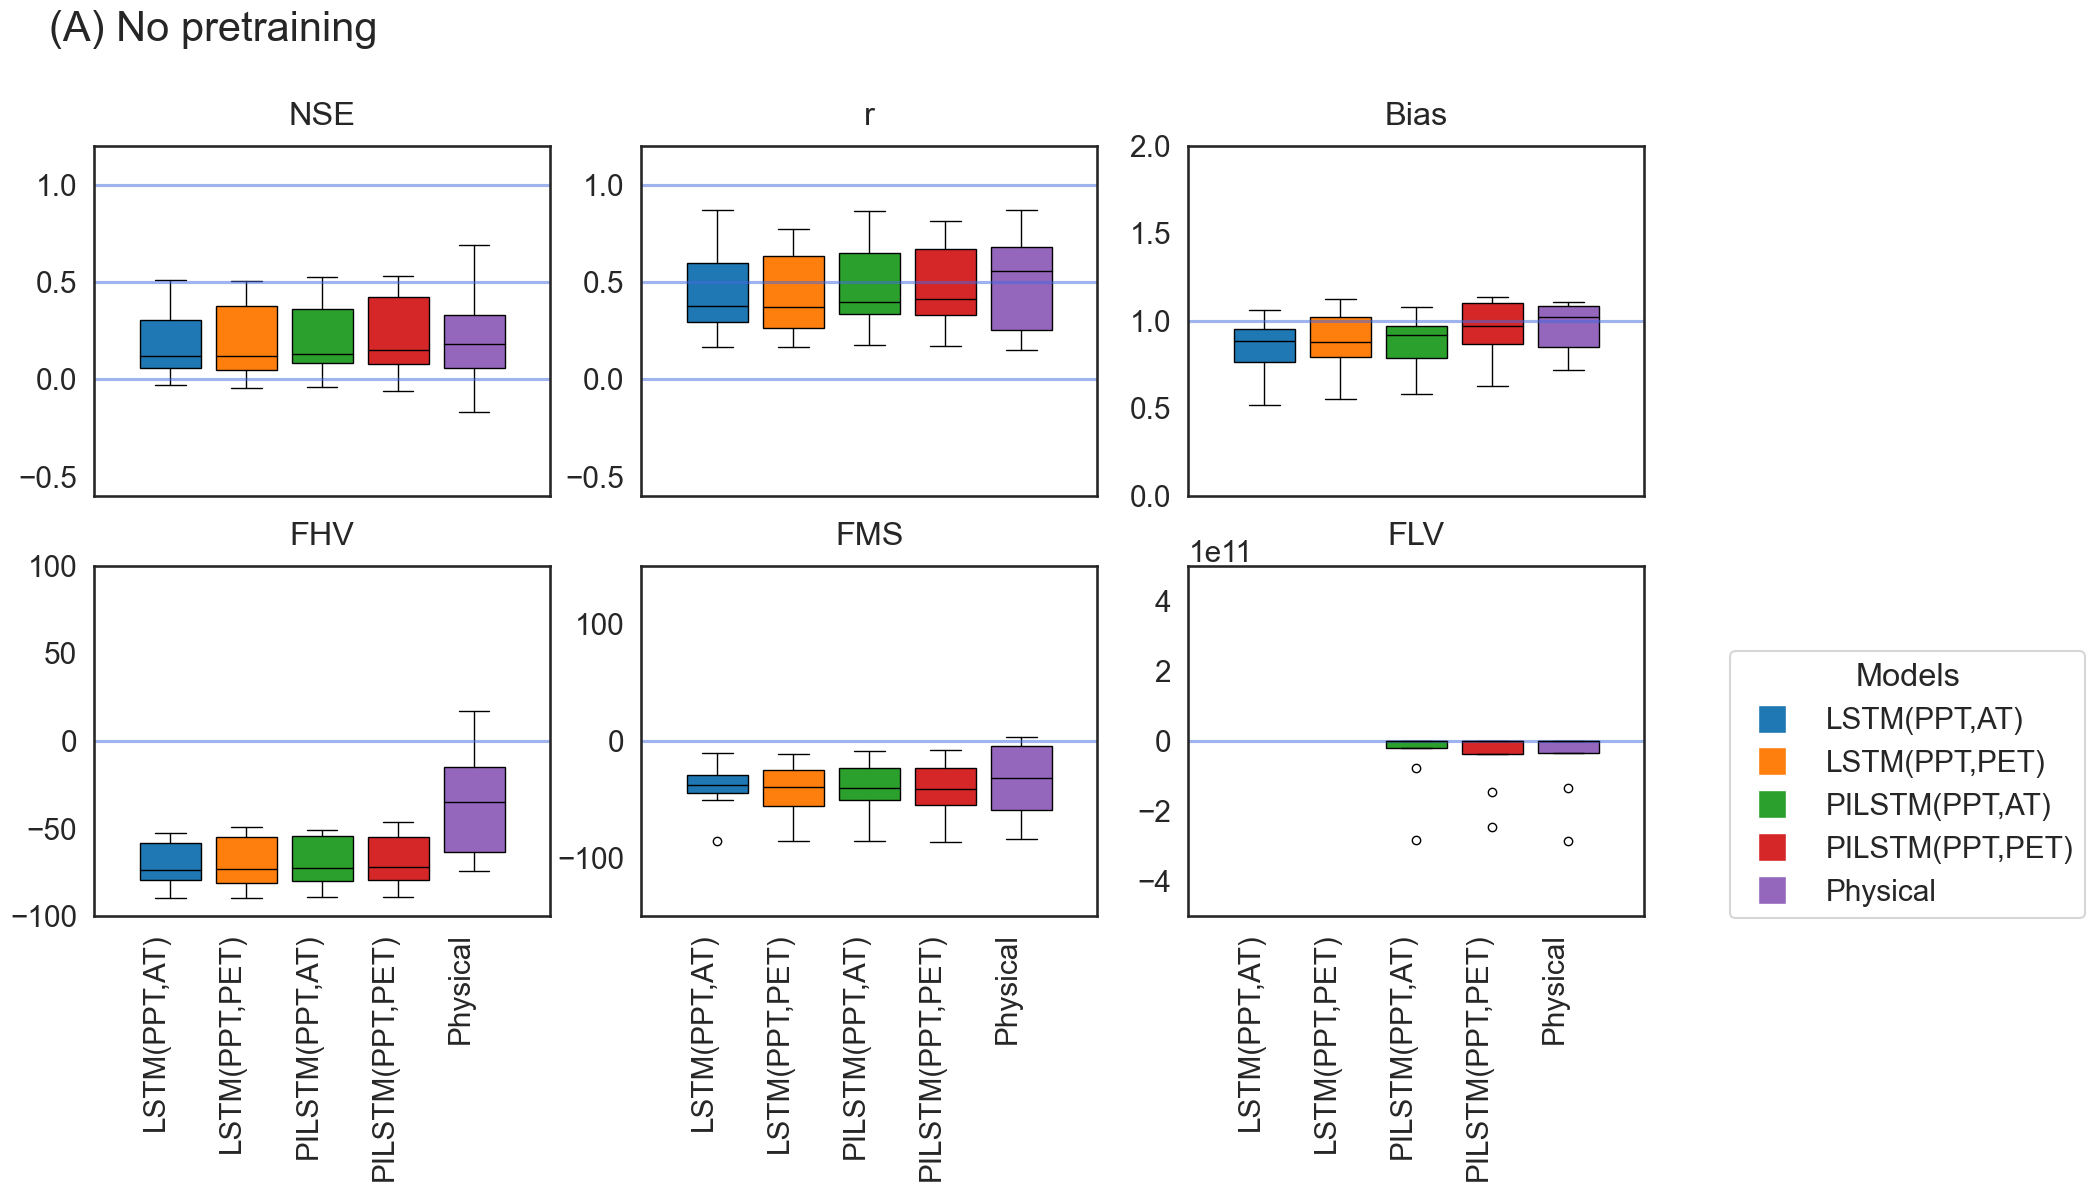

In [162]:
plot_base_exp(res_df_all_base_nopretrain)
plt.savefig('figures/Figure 3A. Model performance in the base experiment without pretraining new.png', 
           bbox_inches='tight', dpi = 200)


## With pretraining

In [163]:
res_df_all_base_ensemble = get_base_exp_result_new(scenario = 'base_ensemble')
res_df_all_base_ensemble

model      watershed  lambda       NSE        FHV         FMS  \
0      LSTM(PPT,AT)       DryCreek    0.00  0.688171  25.942542  -18.039755   
1      LSTM(PPT,AT)      HJAndrews    0.00  0.815614  14.492636  -10.339176   
2      LSTM(PPT,AT)  HarvardForest    0.00  0.792728   4.267532  -18.201609   
3      LSTM(PPT,AT)   HubbardBrook    0.00  0.541507 -21.060380   32.865862   
4      LSTM(PPT,AT)   JornadaBasin    0.00 -1.507085 -33.911629    2.649882   
5      LSTM(PPT,AT)        Kellogg    0.00  0.447412  24.746194   -3.725189   
6      LSTM(PPT,AT)   KonzaPrairie    0.00  0.575171  -5.332804  -77.208443   
7      LSTM(PPT,AT)      Sevilleta    0.00  0.073972 -76.987674  -63.660884   
8     LSTM(PPT,PET)       DryCreek    0.00  0.676532   5.492828  -20.916648   
9     LSTM(PPT,PET)      HJAndrews    0.00  0.606302  10.583686  -23.654826   
10    LSTM(PPT,PET)  HarvardForest    0.00  0.719509 -17.679773  -20.098217   
11    LSTM(PPT,PET)   HubbardBrook    0.00  0.479405 -35.254611  -20.268965   
12    LSTM(PPT,PET)   JornadaBasin    0.00 -4.293432  25.350307  407.199598   
13    LSTM(PPT,PET)        Kellogg    0.00  0.692827  -9.142961  -24.894112   
14    LSTM(PPT,PET)   KonzaPrairie    0.00  0.418993  -9.393645  -84.276131   
15    LSTM(PPT,PET)      Sevilleta    0.00  0.061346 -72.737770   51.400721   
16   PILSTM(PPT,AT)       DryCreek    0.09  0.701636 -12.166616   26.650486   
17   PILSTM(PPT,AT)      HJAndrews    0.03  0.799773   3.902350  -20.250727   
18   PILSTM(PPT,AT)  HarvardForest    0.00  0.787439   1.815977  -20.996024   
19   PILSTM(PPT,AT)   HubbardBrook    0.00  0.545130 -19.215158   16.714679   
20   PILSTM(PPT,AT)   JornadaBasin    0.36 -1.359969 -34.767018  258.712268   
21   PILSTM(PPT,AT)        Kellogg    0.14  0.534915   3.856923  -11.612259   
22   PILSTM(PPT,AT)   KonzaPrairie    0.00  0.601428 -25.174215  -71.631696   
23   PILSTM(PPT,AT)      Sevilleta    0.04  0.123039 -72.502127  -38.596097   
24  PILSTM(PPT,PET)       DryCreek    0.86  0.731066 -22.594536  -13.771696   
25  PILSTM(PPT,PET)      HJAndrews    0.49  0.723119   2.917420   -2.784360   
26  PILSTM(PPT,PET)  HarvardForest    0.00  0.712169  -4.015389  -10.039763   
27  PILSTM(PPT,PET)   HubbardBrook    0.02  0.463756 -35.744077  -33.009685   
28  PILSTM(PPT,PET)   JornadaBasin    0.03 -3.480738  38.998205  461.276341   
29  PILSTM(PPT,PET)        Kellogg    0.25  0.647315 -14.212330  -49.047627   
30  PILSTM(PPT,PET)   KonzaPrairie    0.00  0.553259 -10.784647  -75.122701   
31  PILSTM(PPT,PET)      Sevilleta    0.03  0.039078 -67.716098   44.639409   
32         Physical       DryCreek     NaN  0.690000 -28.600000    2.960000   
33         Physical      HJAndrews     NaN  0.670000  17.320000   -7.170000   
34         Physical  HarvardForest     NaN  0.220000 -20.240000  -13.060000   
35         Physical   HubbardBrook     NaN  0.030000 -60.130000  -50.350000   
36         Physical   JornadaBasin     NaN -0.170000 -40.980000  -51.470000   
37         Physical        Kellogg     NaN  0.170000   0.080000    2.420000   
38         Physical   KonzaPrairie     NaN  0.070000 -74.010000  -82.380000   
39         Physical      Sevilleta     NaN  0.190000 -74.580000  -84.100000   

             FLV         r      Bias  
0  -4.253453e+01  0.871040  0.850978  
1   4.288614e+01  0.909921  1.011107  
2   2.801630e+01  0.899699  1.094414  
3  -2.705754e+02  0.735972  1.011935  
4  -6.831205e+01 -0.019623  4.112483  
5   1.356662e+01  0.801789  1.039132  
6  -1.429016e+11  0.766154  1.333787  
7  -4.406180e+10  0.274425  1.240063  
8   8.541703e+01  0.833888  0.885720  
9   7.391610e+00  0.805185  1.094109  
10  4.572128e+01  0.852740  1.087237  
11 -1.822047e+02  0.711521  1.085597  
12  9.599393e+01  0.027828  3.593207  
13  1.555709e+01  0.833085  1.012694  
14 -2.427226e+11  0.663267  1.309375  
15  0.000000e+00  0.270047  0.889561  
16  2.245724e+01  0.870400  0.712109  
17 -5.193872e+01  0.896115  1.000577  
18 -5.096903e+01  0.895097  1.103

In [164]:
# get the NSE values for Table.3
res_df_all_nse_pivot_ensemble = get_base_exp_nse_table(res_df_all_base_ensemble)
res_df_all_nse_pivot_ensemble.to_csv('tables/Table 4B. Model Nash-Sutcliffe Efficiency (NSE) in the base experiment with pretraining new.csv')
res_df_all_nse_pivot_ensemble

model          LSTM(PPT,AT)  LSTM(PPT,PET)  PILSTM(PPT,AT)  PILSTM(PPT,PET)  \
watershed                                                                     
DryCreek               0.69           0.68            0.70             0.73   
HJAndrews              0.82           0.61            0.80             0.72   
HarvardForest          0.79           0.72            0.79             0.71   
HubbardBrook           0.54           0.48            0.55             0.46   
JornadaBasin          -1.51          -4.29           -1.36            -3.48   
Kellogg                0.45           0.69            0.53             0.65   
KonzaPrairie           0.58           0.42            0.60             0.55   
Sevilleta              0.07           0.06            0.12             0.04   

model          Physical  
watershed                
DryCreek           0.69  
HJAndrews          0.67  
HarvardForest      0.22  
HubbardBrook       0.03  
JornadaBasin      -0.17  
Kellogg            0.17  
KonzaPrairie       0.07  
Sevilleta          0.19

/var/folders/xj/q38s9lg550sfgkfvnw1gfblr0000gn/T/ipykernel_67659/1889817250.py:86: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


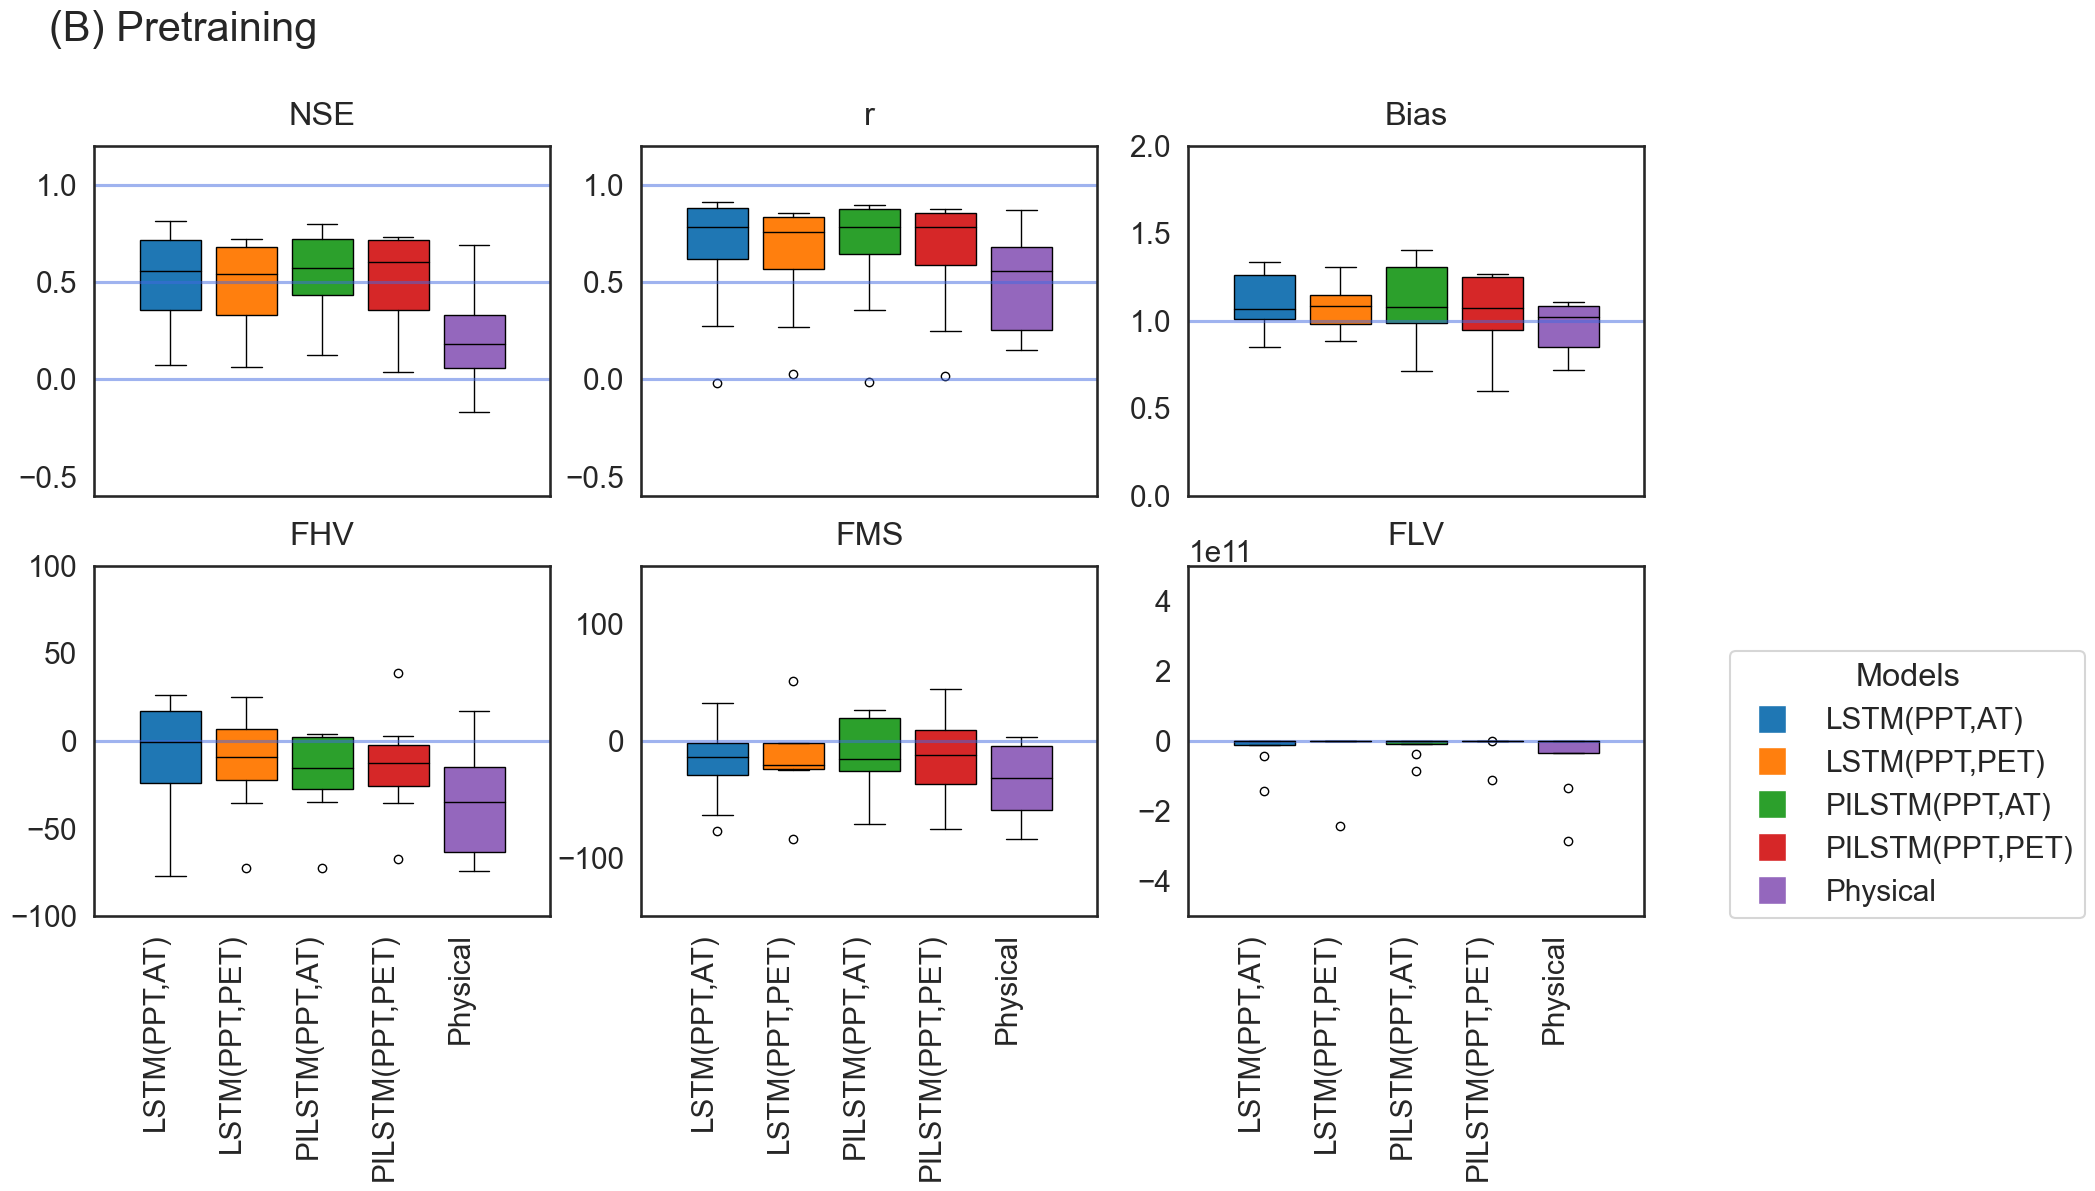

In [165]:
plot_base_exp(res_df_all_base_ensemble, pretrain = True)
plt.savefig('figures/Figure 3B. Model performance in the base experiment across eight watersheds with pretraining new.png', 
            bbox_inches='tight',
            dpi = 200)


## Get lambda values

In [92]:
def get_lambda_table(df):
    df_lambda = df[(df['model']=='PILSTM(PPT,AT)')|(df['model']=='PILSTM(PPT,PET)')][['model','watershed','lambda']]
    df_lambda = df_lambda.pivot(index = 'watershed', columns = 'model', values = 'lambda')
    return df_lambda


In [93]:
lambda_nopretrain = get_lambda_table(res_df_all_base_nopretrain)
lambda_nopretrain.columns = lambda_nopretrain.columns + '_nopretrain'
lambda_nopretrain

model          PILSTM(PPT,AT)_nopretrain  PILSTM(PPT,PET)_nopretrain
watershed                                                           
DryCreek                            0.33                        0.55
HJAndrews                           0.57                        0.60
HarvardForest                       0.35                        0.26
HubbardBrook                        0.18                        0.08
JornadaBasin                        0.28                        0.26
Kellogg                             0.16                        0.21
KonzaPrairie                        0.14                        0.10
Sevilleta                           0.11                        0.32

In [94]:
lambda_pretrain = get_lambda_table(res_df_all_base_ensemble)
lambda_pretrain.columns = lambda_pretrain.columns + '_pretrain'
lambda_pretrain

model          PILSTM(PPT,AT)_pretrain  PILSTM(PPT,PET)_pretrain
watershed                                                       
DryCreek                          0.09                      0.86
HJAndrews                         0.03                      0.49
HarvardForest                     0.00                      0.00
HubbardBrook                      0.00                      0.02
JornadaBasin                      0.36                      0.03
Kellogg                           0.14                      0.25
KonzaPrairie                      0.00                      0.00
Sevilleta                         0.04                      0.03

In [96]:
lambda_df = pd.concat([lambda_nopretrain, lambda_pretrain], axis = 1)
lambda_df.to_csv('tables/Table 5.lamba_value_base_exp.csv')
lambda_df

model          PILSTM(PPT,AT)_nopretrain  PILSTM(PPT,PET)_nopretrain  \
watershed                                                              
DryCreek                            0.33                        0.55   
HJAndrews                           0.57                        0.60   
HarvardForest                       0.35                        0.26   
HubbardBrook                        0.18                        0.08   
JornadaBasin                        0.28                        0.26   
Kellogg                             0.16                        0.21   
KonzaPrairie                        0.14                        0.10   
Sevilleta                           0.11                        0.32   

model          PILSTM(PPT,AT)_pretrain  PILSTM(PPT,PET)_pretrain  
watershed                                                         
DryCreek                          0.09                      0.86  
HJAndrews                         0.03                      0.49  
HarvardForest                     0.00                      0.00  
HubbardBrook                      0.00                      0.02  
JornadaBasin                      0.36                      0.03  
Kellogg                           0.14                      0.25  
KonzaPrairie                      0.00                      0.00  
Sevilleta                         0.04                      0.03

# Data-scarce scenario expeirments

In [16]:
watersheds = ['DryCreek','HJAndrews','HarvardForest','HubbardBrook',
              'JornadaBasin','Kellogg','KonzaPrairie','Sevilleta']

dir_path = '/Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment'
res = []

for watershed in watersheds[:]:
    print('\n', watershed)
    watershed_lower_case = watershed.lower()
    
    yml_files = glob.glob(f"{dir_path}/LSTM_AT_PPT/runs/datascarce/*_finetune_{watershed_lower_case}_*/config.yml")
    par_files = glob.glob(f"{dir_path}/calibration_results/{watershed}_QSmodel_parameters_searching_*")
        
    if not yml_files:
        continue
        
    for training_years in range(1,7):
        print('\n', training_years)
        # get yml file
        for file in yml_files:
            folder = file.rsplit('/',2)[-2]
            
            if get_training_years(folder)==training_years:
                yaml_file_path = file
                print('yaml_file_path is', yaml_file_path)
                print()

        
        res_d = physical_model_performance_base_experiment(watershed = watershed,
                                                           yaml_file_path = yaml_file_path,
                                                           data_path = '/Users/angelikazhang/Desktop/PILSTM/chosen/',
                                                          )
        res_d['training_years'] = training_years
        res.append(res_d)
    
phy_res_df = pd.DataFrame(res)


 DryCreek

 1
yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/runs/datascarce/lstm_531_PPT_AT_finetune_drycreek_None_2011-10-0100_00_00_2012-09-3000_00_00_1711_015649/config.yml

train_start_dates are [datetime.datetime(2011, 10, 1, 0, 0)]
train_end_dates are [datetime.datetime(2012, 9, 30, 0, 0)]
par_file_name is DryCreek_QSmodel_parameters_searching_2011-10-01_2012-09-30.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-4.0030761345924795, -0.8132525619430933], 'c2': [-4.2296540616707485, 5.427875041024629], 'c3': [-3.3678085354729004, 4.572174237296084], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is DryCreek_QSmodel_parameters_searching_2011-10-01_2012-09-30.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-3.10768364496


 HJAndrews

 1
yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/runs/datascarce/lstm_531_PPT_AT_finetune_hjandrews_None_2011-10-0100_00_00_2012-09-3000_00_00_1711_020110/config.yml

train_start_dates are [datetime.datetime(2011, 10, 1, 0, 0)]
train_end_dates are [datetime.datetime(2012, 9, 30, 0, 0)]
par_file_name is HJAndrews_QSmodel_parameters_searching_2011-10-01_2012-09-30.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-10.300525622268111, 7.222846438943031], 'c2': [-5.380571952795528, 4.780132052165355], 'c3': [-0.590843590221811, 0.9024374600946525], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is HJAndrews_QSmodel_parameters_searching_2011-10-01_2012-09-30.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-4.7901770426


 HarvardForest

 1
yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/runs/datascarce/lstm_531_PPT_AT_finetune_harvardforest_None_2014-01-0100_00_00_2014-12-3100_00_00_1711_020531/config.yml

train_start_dates are [datetime.datetime(2014, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2014, 12, 31, 0, 0)]
par_file_name is HarvardForest_QSmodel_parameters_searching_2014-01-01_2014-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-437.41074001932515, 491.1249250466653], 'c2': [-618.1514249262519, 545.8950292025312], 'c3': [-170.32889158285008, 193.50002707492712], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is HarvardForest_QSmodel_parameters_searching_2014-01-01_2014-12-31.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1

/Users/angelikazhang/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))



 2
yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/runs/datascarce/lstm_531_PPT_AT_finetune_harvardforest_None_2013-01-0100_00_00_2014-12-3100_00_00_1711_020456/config.yml

train_start_dates are [datetime.datetime(2013, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2014, 12, 31, 0, 0)]
par_file_name is HarvardForest_QSmodel_parameters_searching_2013-01-01_2014-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-7.781155326095326, 2.6041888148793264], 'c2': [-4.763780436768563, 6.696452361424065], 'c3': [-1.6141116611588284, 1.5233916230876057], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is HarvardForest_QSmodel_parameters_searching_2013-01-01_2014-12-31.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-4.220913395

/Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/neuralhydrology/datautils/QS_physical_model.py:480: RuntimeWarning: overflow encountered in exp
  Q_curr = np.exp( np.log(Q_former) + delta)



 3
yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/runs/datascarce/lstm_531_PPT_AT_finetune_harvardforest_None_2012-01-0100_00_00_2014-12-3100_00_00_1711_020415/config.yml

train_start_dates are [datetime.datetime(2012, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2014, 12, 31, 0, 0)]
par_file_name is HarvardForest_QSmodel_parameters_searching_2012-01-01_2014-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-6.093172115882757, 0.05401024296466961], 'c2': [-1.993178018599512, 5.088903539247413], 'c3': [-1.2534007525761166, 0.8041131084726864], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is HarvardForest_QSmodel_parameters_searching_2012-01-01_2014-12-31.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-4.72173370


 3
yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/runs/datascarce/lstm_531_PPT_AT_finetune_hubbardbrook_None_2002-01-0100_00_00_2004-12-3100_00_00_1711_020843/config.yml

train_start_dates are [datetime.datetime(2002, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2004, 12, 31, 0, 0)]
par_file_name is HubbardBrook_QSmodel_parameters_searching_2002-01-01_2004-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-7.048328876773284, 1.0351382709137367], 'c2': [-1.2217435322693395, 4.272023938398746], 'c3': [-0.67778824601325, 0.24669800656830468], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is HubbardBrook_QSmodel_parameters_searching_2002-01-01_2004-12-31.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-4.428429605536

/Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/neuralhydrology/datautils/QS_physical_model.py:480: RuntimeWarning: overflow encountered in exp
  Q_curr = np.exp( np.log(Q_former) + delta)


train_start_dates are [datetime.datetime(2005, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2006, 12, 31, 0, 0)]
par_file_name is JornadaBasin_QSmodel_parameters_searching_2005-01-01_2006-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-10.440960789010212, 1.2063793743431868], 'c2': [-5.836039792725693, 0.550259445995875], 'c3': [-0.7802835772221474, 0.07260411479949036], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is JornadaBasin_QSmodel_parameters_searching_2005-01-01_2006-12-31.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-0.3738622129782885, 1.2063793743431868), 'c2': (-0.08016914043109025, 0.550259445995875), 'c3': (-0.04966582149638568, 0.07260411479949036), 'runoff_coef': (0.8831360762377554, 0.9)}
Reach maximum iterations! Stop optimization.
Saved results 


 2
yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/runs/datascarce/lstm_531_PPT_AT_finetune_kellogg_None_2012-01-0100_00_00_2013-12-3100_00_00_1711_021809/config.yml

train_start_dates are [datetime.datetime(2012, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2013, 12, 31, 0, 0)]
par_file_name is Kellogg_QSmodel_parameters_searching_2012-01-01_2013-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-3.1207369492072243, -2.211983032435875], 'c2': [-0.18084300388650787, 3.268427514749679], 'c3': [-2.3581851499109696, 0.5553063358836694], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is Kellogg_QSmodel_parameters_searching_2012-01-01_2013-12-31.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-3.1207369492072243, -3.120


 2
yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/runs/datascarce/lstm_531_PPT_AT_finetune_konzaprairie_None_2013-10-0100_00_00_2015-09-3000_00_00_1711_022232/config.yml

train_start_dates are [datetime.datetime(2013, 10, 1, 0, 0)]
train_end_dates are [datetime.datetime(2015, 9, 30, 0, 0)]
par_file_name is KonzaPrairie_QSmodel_parameters_searching_2013-10-01_2015-09-30.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-2.6081193390114223, -1.5957166539373255], 'c2': [-0.18361056841090195, 1.983911089149658], 'c3': [-0.3428748439710406, 0.5512522196842632], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is KonzaPrairie_QSmodel_parameters_searching_2013-10-01_2015-09-30.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-2.13383846

Current parameter range is {'c1': (-9.115568154472342, 10.476335265511551), 'c2': (0.34905364364101565, 21.874153052156746), 'c3': (-0.1592258922798655, 3.1226021091033482), 'runoff_coef': (0.1, 0.9)}
Reach maximum iterations! Stop optimization.
Saved results have converged. Set up the optimal parameters...
Set up the optimal parameters...
Done with QS model initialization.
Input values for parameters are not found, use the saved optimal parameters of the model

 2
yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/runs/datascarce/lstm_531_PPT_AT_finetune_sevilleta_None_2013-01-0100_00_00_2014-12-3100_00_00_1711_022654/config.yml

train_start_dates are [datetime.datetime(2013, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2014, 12, 31, 0, 0)]
par_file_name is Sevilleta_QSmodel_parameters_searching_2013-01-01_2014-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Pre

/Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/neuralhydrology/datautils/QS_physical_model.py:480: RuntimeWarning: overflow encountered in exp
  Q_curr = np.exp( np.log(Q_former) + delta)



Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-1.6191817513249023, 0.006369431266296521], 'c2': [-1.237517122810383, 0.692609515818041], 'c3': [-0.2078364330064843, 0.14600306760899584], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is Sevilleta_QSmodel_parameters_searching_2012-01-01_2014-12-31.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-0.7526952880424763, -0.46209952330142634), 'c2': (0.0839892437833409, 0.237956063522961), 'c3': (-0.13850410648868924, -0.1193887066902841), 'runoff_coef': (0.29289108698474103, 0.32854143607296155)}
Reach maximum iterations! Stop optimization.
Saved results have converged. Set up the optimal parameters...
Set up the optimal parameters...
Done with QS model initialization.
Input values for parameters are not found, use the saved optimal paramet

In [17]:
phy_res_df = phy_res_df[['training_years', 'watershed', 'NSE']]
phy_res_df['lambda'] = None
phy_res_df['model']='physical'
phy_res_df

training_years      watershed        NSE lambda     model
0                1       DryCreek       0.14   None  physical
1                2       DryCreek       0.77   None  physical
2                3       DryCreek       0.69   None  physical
3                4       DryCreek       0.77   None  physical
4                5       DryCreek       0.76   None  physical
5                6       DryCreek       0.69   None  physical
6                1      HJAndrews       0.54   None  physical
7                2      HJAndrews       0.55   None  physical
8                3      HJAndrews       0.62   None  physical
9                4      HJAndrews       0.43   None  physical
10               5      HJAndrews       0.41   None  physical
11               6      HJAndrews       0.67   None  physical
12               1  HarvardForest      -0.28   None  physical
13               2  HarvardForest -388576.06   None  physical
14               3  HarvardForest       0.21   None  physical
15               4  HarvardForest       0.23   None  physical
16               5  HarvardForest    -512.29   None  physical
17               6  HarvardForest       0.22   None  physical
18               1   HubbardBrook      -0.06   None  physical
19               2   HubbardBrook       0.02   None  physical
20               3   HubbardBrook      -0.01   None  physical
21               4   HubbardBrook      -0.12   None  physical
22               5   HubbardBrook       0.03   None  physical
23               6   HubbardBrook       0.03   None  physical
24               1   JornadaBasin      -1.92   None  physical
25               2   JornadaBasin      -0.51   None  physical
26               3   JornadaBasin      -0.31   None  physical
27               4   JornadaBasin      -0.03   None  physical
28               5   JornadaBasin      -0.02   None  physical
29               6   JornadaBasin      -0.17   None  physical
30               1        Kellogg       0.07   None  physical
31               2        Kellogg       0.25   None  physical
32               3        Kellogg       0.18   None  physical
33               4        Kellogg       0.21   None  physical
34               5        Kellogg       0.15   None  physical
35               6        Kellogg       0.17   None  physical
36               1   KonzaPrairie      -0.42   None  physical
37               2   KonzaPrairie       0.08   None  physical
38               3   KonzaPrairie       0.09   None  physical
39               4   KonzaPrairie       0.09   None  physical
40               5   KonzaPrairie       0.11   None  physical
41               6   KonzaPrairie       0.07   None  physical
42               1      Sevilleta       0.05   None  physical
43               2      Sevilleta      -2.58   None  physical
44               3      Sevilleta       0.26   None  physical
45               4      Sevilleta       0.29   None  physical
46               5      Sevilleta       0.29   None  physical
47               6      Sevilleta       0.19   None  physical

## No pretraining ensemble run

In [18]:
dir_path = '/Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment'
scenario = 'datascarce_nopretrain'

exps = [ 'LSTM_AT_PPT', 'LSTM_ET_PPT', 'PILSTM_PPT_AT_1out', 'PILSTM_PPT_ET_1out'] # ,

exp_name_d = {'LSTM_AT_PPT':'LSTM(PPT,AT)',
              'LSTM_ET_PPT':'LSTM(PPT,PET)',
              'PILSTM_PPT_AT_1out': 'PILSTM(PPT,AT)',
              'PILSTM_PPT_ET_1out': 'PILSTM(PPT,PET)'}

res_df = pd.DataFrame()

for watershed in watersheds[:]:
    watershed_lower = watershed.lower()
    
    for exp in exps:
        if 'PILSTM' in exp:
            #Q_col = 'Qpilstm(mm/d)'
            eval_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}_new/{exp}_{scenario}_new_{watershed_lower}_eval_result.csv',index_col=0)
            eval_df = eval_df[['training_years', 'watershed', 'NSE', 'lambda', 'seed','optimal_epoch']]
            
            valid_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}_new/{exp}_{scenario}_new_{watershed_lower}_validation_result.csv',index_col=0)

        else:
            Q_col = 'QObs(mm/d)'
            eval_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_eval_result.csv',index_col=0)
            
            eval_df = eval_df[['training_years', 'watershed', f'{Q_col}_NSE', 'lambda', 'seed','optimal_epoch']]
            valid_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_validation_result.csv',index_col=0)

        # find the optimal epoch and lambda for each dry_wet_index, each seed
        valid_df_optimal = valid_df.loc[valid_df.groupby(['watershed','training_years', 'seed'])['NSE'].idxmax()][['watershed','training_years','seed', 'lambda', 'epoch']]
        
        eval_df_optimal = pd.merge(eval_df, valid_df_optimal, on=['watershed','training_years','seed', 'lambda'], how='inner')
        
        eval_df_optimal.rename(columns = {f'{Q_col}_NSE':'NSE'},inplace = True)
        eval_df_optimal = eval_df_optimal.groupby(['training_years']).mean(numeric_only=True).reset_index()
        
        eval_df_optimal['watershed'] = watershed
        eval_df_optimal['model'] = exp_name_d[exp]

        res_df = pd.concat([res_df, eval_df_optimal], ignore_index=True)

exp_res_df = copy.deepcopy(res_df)
exp_res_df                             

training_years       NSE  lambda   seed  optimal_epoch  epoch  watershed  \
0                 1  0.260407    0.00  569.9           10.0   10.0   DryCreek   
1                 2  0.425097    0.00  569.9            5.9    5.9   DryCreek   
2                 3  0.413690    0.00  569.9            8.6    8.6   DryCreek   
3                 4  0.454850    0.00  569.9           14.5   14.5   DryCreek   
4                 5  0.446175    0.00  569.9           15.4   15.4   DryCreek   
..              ...       ...     ...    ...            ...    ...        ...   
187               2  0.011605    0.51  569.9           19.4   19.4  Sevilleta   
188               3  0.035141    0.17  569.9           23.5   23.5  Sevilleta   
189               4  0.040406    0.19  569.9           21.6   21.6  Sevilleta   
190               5  0.057636    0.27  569.9           23.9   23.9  Sevilleta   
191               6  0.082900    0.32  569.9           22.0   22.0  Sevilleta   

               model  
0       LSTM(PPT,AT)  
1       LSTM(PPT,AT)  
2       LSTM(PPT,AT)  
3       LSTM(PPT,AT)  
4       LSTM(PPT,AT)  
..               ...  
187  PILSTM(PPT,PET)  
188  PILSTM(PPT,PET)  
189  PILSTM(PPT,PET)  
190  PILSTM(PPT,PET)  
191  PILSTM(PPT,PET)  

[192 rows x 8 columns]

In [19]:
res_df = pd.concat([res_df, phy_res_df], axis=0)

# subset the PILSTM models
res_df_sub = res_df[(res_df['model']=='PILSTM(PPT,PET)')| (res_df['model']=='PILSTM(PPT,AT)')]
res_df_sub['training_years'] = res_df_sub['training_years'] - 1

#bool1 = res_df_sub['model']=='PILSTM(PPT,PET)'
#bool2 = res_df_sub['model']=='PILSTM(PPT,AT)'

#res_df_sub.loc[bool1, 'training_years'] = res_df_sub.loc[bool1, 'training_years'] - 0.72
#res_df_sub.loc[bool2, 'training_years'] = res_df_sub.loc[bool2, 'training_years'] - 0.92

/var/folders/xj/q38s9lg550sfgkfvnw1gfblr0000gn/T/ipykernel_2833/1806290327.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df_sub['training_years'] = res_df_sub['training_years'] - 1


In [25]:
res_df_6 = res_df[res_df['training_years']==6]
res_df_6_lstm_at = res_df_6[res_df_6['model']=='LSTM(PPT,AT)']
res_df_6_lstm_at

training_years       NSE  lambda   seed  optimal_epoch  epoch  \
5                 6  0.509931     0.0  569.9           24.7   24.7   
29                6  0.379528     0.0  569.9           17.0   17.0   
53                6  0.147167     0.0  569.9           18.7   18.7   
77                6  0.091164     0.0  569.9           27.4   27.4   
101               6 -0.028765     0.0  569.9           26.6   26.6   
125               6  0.277746     0.0  569.9           19.2   19.2   
149               6  0.059174     0.0  569.9           15.5   15.5   
173               6  0.054541     0.0  569.9           19.7   19.7   

         watershed         model  
5         DryCreek  LSTM(PPT,AT)  
29       HJAndrews  LSTM(PPT,AT)  
53   HarvardForest  LSTM(PPT,AT)  
77    HubbardBrook  LSTM(PPT,AT)  
101   JornadaBasin  LSTM(PPT,AT)  
125        Kellogg  LSTM(PPT,AT)  
149   KonzaPrairie  LSTM(PPT,AT)  
173      Sevilleta  LSTM(PPT,AT)

/var/folders/xj/q38s9lg550sfgkfvnw1gfblr0000gn/T/ipykernel_2833/1642805290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df_sub['training_years'] = res_df_sub['training_years'] - 1


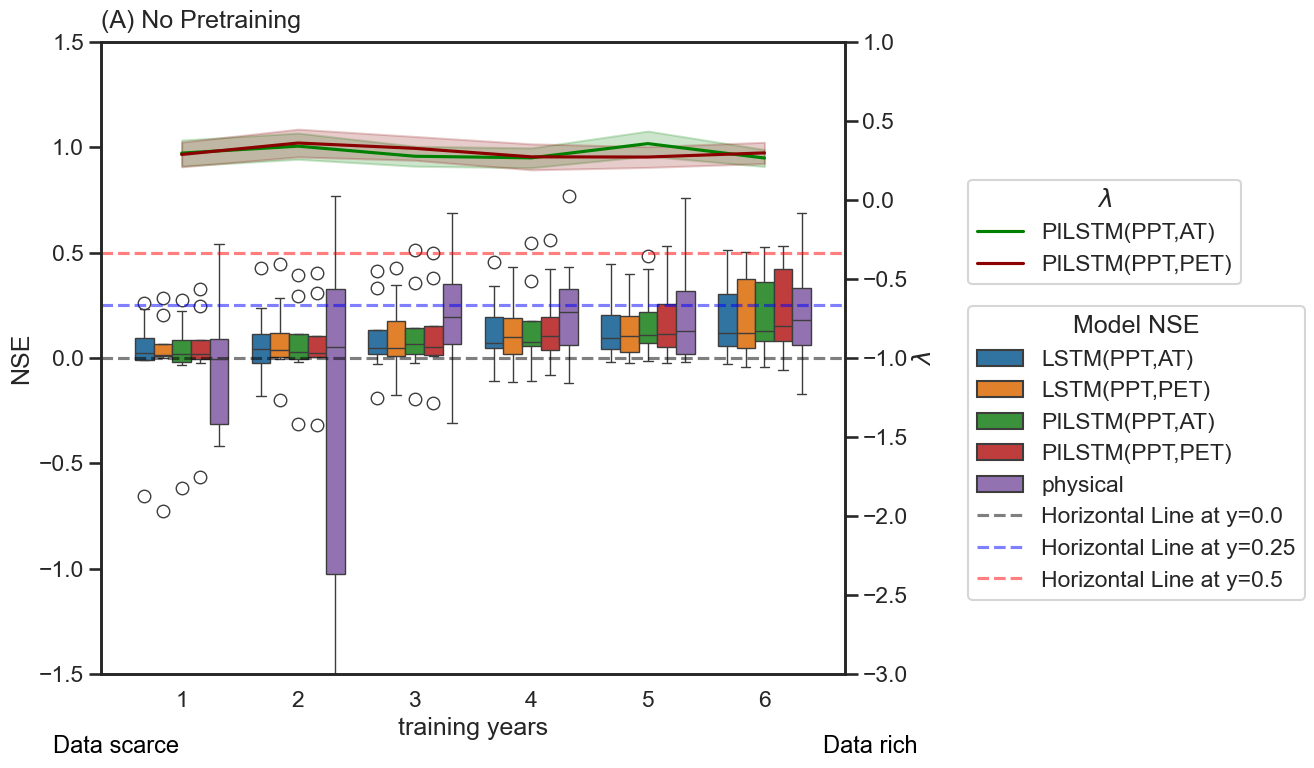

In [20]:
res_df = pd.concat([exp_res_df, phy_res_df], axis=0)
res_df_sub = res_df[(res_df['model']=='PILSTM(PPT,PET)' )|(res_df['model']=='PILSTM(PPT,AT)' )]
res_df_sub['training_years'] = res_df_sub['training_years'] - 1

# start plotting
sns.set_context("talk", font_scale = 1)
fig, ax1 = plt.subplots(figsize=(14,8))
ax2 = ax1.twinx()

######## 1st plot
sns.boxplot(data=res_df, x="training_years", y="NSE", hue="model", ax=ax1)#,errorbar=None)
ax1.set_ylim(-1.5,1.5)

######## 2nd plot
sns.lineplot(data=res_df_sub, x='training_years', y='lambda', hue='model',
             ax=ax2, errorbar=('se'), 
             palette={'PILSTM(PPT,AT)': 'green', 'PILSTM(PPT,PET)': 'darkred'})

ax2.set_ylim(-3,1)

# legends
ax1.axhline(y=0, color='black', alpha=0.5, linestyle='--', label='Horizontal Line at y=0.0')
ax1.axhline(y=0.25, color='blue', alpha=0.5, linestyle='--', label='Horizontal Line at y=0.25')
ax1.axhline(y=0.5, color='red', alpha=0.5, linestyle='--', label='Horizontal Line at y=0.5')
legend1 = ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 0.6))

legend1.set_title('Model NSE')

legend2 = ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.8))
legend2.set_title(r'$\lambda$')

ax1.set_xlabel('training years')

plt.title('(A) No Pretraining', loc='left', pad=10)

ax2.text(-1.1, -3.5, 'Data scarce', fontsize=17, color='black')
ax2.text(5.5, -3.5, 'Data rich', fontsize=17, color='black')
ax2.set_ylabel(r'$\lambda$')

plt.tight_layout()
#plt.savefig('figures/Figure 5A.data_scarce_nopretrain.jpg', dpi=200)

In [21]:
res_df_sub['lambda'].median()

0.255

In [22]:
res_df_sub['lambda'].mean()

0.30125

## Pretraining ensemble run

In [26]:
dir_path = '/Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment'
scenario = 'datascarce_ensemble'

exps = [ 'LSTM_AT_PPT', 'LSTM_ET_PPT', 'PILSTM_PPT_AT_1out', 'PILSTM_PPT_ET_1out'] # ,

exp_name_d = {'LSTM_AT_PPT':'LSTM(PPT,AT)',
              'LSTM_ET_PPT':'LSTM(PPT,PET)',
              'PILSTM_PPT_AT_1out': 'PILSTM(PPT,AT)',
              'PILSTM_PPT_ET_1out': 'PILSTM(PPT,PET)'}

res_df = pd.DataFrame()

for watershed in watersheds[:]:
    watershed_lower = watershed.lower()
    
    for exp in exps:
        if 'PILSTM' in exp:
            eval_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}_new/{exp}_{scenario}_new_{watershed_lower}_eval_result.csv',index_col=0)
            eval_df = eval_df[['training_years', 'watershed', f'NSE', 'lambda', 'seed','optimal_epoch']]
            valid_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}_new/{exp}_{scenario}_new_{watershed_lower}_validation_result.csv',index_col=0)

        else:
            Q_col = 'QObs(mm/d)'
            eval_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_eval_result.csv',index_col=0)
            eval_df = eval_df[['training_years', 'watershed', f'{Q_col}_NSE', 'lambda', 'seed','optimal_epoch']]
            valid_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_validation_result.csv',index_col=0)

        # find the optimal epoch and lambda for each dry_wet_index, each seed
        valid_df_optimal = valid_df.loc[valid_df.groupby(['watershed','training_years', 'seed'])['NSE'].idxmax()][['watershed','training_years','seed', 'lambda', 'epoch']]
        
        eval_df_optimal = pd.merge(eval_df, valid_df_optimal, on=['watershed','training_years','seed', 'lambda'], how='inner')
        
        eval_df_optimal.rename(columns = {f'{Q_col}_NSE':'NSE'},inplace = True)
        eval_df_optimal = eval_df_optimal.groupby(['training_years']).mean(numeric_only=True).reset_index()
        
        eval_df_optimal['watershed'] = watershed
        eval_df_optimal['model'] = exp_name_d[exp]

        res_df = pd.concat([res_df, eval_df_optimal], ignore_index=True)

exp_res_df = copy.deepcopy(res_df)
exp_res_df                             

training_years       NSE  lambda   seed  optimal_epoch  epoch  watershed  \
0                 1  0.270846    0.00  569.9           23.0   23.0   DryCreek   
1                 2  0.657208    0.00  569.9           20.2   20.2   DryCreek   
2                 3  0.685118    0.00  569.9           11.8   11.8   DryCreek   
3                 4  0.689053    0.00  569.9            7.7    7.7   DryCreek   
4                 5  0.694866    0.00  569.9           20.0   20.0   DryCreek   
..              ...       ...     ...    ...            ...    ...        ...   
187               2 -0.053089    0.72  569.9           19.7   19.7  Sevilleta   
188               3 -0.026357    0.54  569.9           12.9   12.9  Sevilleta   
189               4  0.001267    0.48  569.9           13.2   13.2  Sevilleta   
190               5  0.037574    0.00  569.9           19.6   19.6  Sevilleta   
191               6  0.039078    0.03  569.9           19.1   19.1  Sevilleta   

               model  
0       LSTM(PPT,AT)  
1       LSTM(PPT,AT)  
2       LSTM(PPT,AT)  
3       LSTM(PPT,AT)  
4       LSTM(PPT,AT)  
..               ...  
187  PILSTM(PPT,PET)  
188  PILSTM(PPT,PET)  
189  PILSTM(PPT,PET)  
190  PILSTM(PPT,PET)  
191  PILSTM(PPT,PET)  

[192 rows x 8 columns]

In [27]:
res_df = pd.concat([res_df, phy_res_df], axis=0)

# subset the PILSTM models
res_df_sub = res_df[(res_df['model']=='PILSTM(PPT,PET)')| (res_df['model']=='PILSTM(PPT,AT)')]
res_df_sub['training_years'] = res_df_sub['training_years'] - 1

#bool1 = res_df_sub['model']=='PILSTM(PPT,PET)'
#bool2 = res_df_sub['model']=='PILSTM(PPT,AT)'

#res_df_sub.loc[bool1, 'training_years'] = res_df_sub.loc[bool1, 'training_years'] - 0.72
#res_df_sub.loc[bool2, 'training_years'] = res_df_sub.loc[bool2, 'training_years'] - 0.92

/var/folders/xj/q38s9lg550sfgkfvnw1gfblr0000gn/T/ipykernel_2833/1806290327.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df_sub['training_years'] = res_df_sub['training_years'] - 1


In [28]:
res_df_6 = res_df[res_df['training_years']==6]
res_df_6_lstm_at = res_df_6[res_df_6['model']=='LSTM(PPT,AT)']
res_df_6_lstm_at

training_years       NSE  lambda   seed  optimal_epoch  epoch  \
5                 6  0.688171     0.0  569.9           21.8   21.8   
29                6  0.815614     0.0  569.9           22.9   22.9   
53                6  0.792728     0.0  569.9            8.4    8.4   
77                6  0.541507     0.0  569.9           30.0   30.0   
101               6 -1.507085     0.0  569.9           27.7   27.7   
125               6  0.447412     0.0  569.9           29.7   29.7   
149               6  0.575171     0.0  569.9           21.1   21.1   
173               6  0.073972     0.0  569.9           27.7   27.7   

         watershed         model  
5         DryCreek  LSTM(PPT,AT)  
29       HJAndrews  LSTM(PPT,AT)  
53   HarvardForest  LSTM(PPT,AT)  
77    HubbardBrook  LSTM(PPT,AT)  
101   JornadaBasin  LSTM(PPT,AT)  
125        Kellogg  LSTM(PPT,AT)  
149   KonzaPrairie  LSTM(PPT,AT)  
173      Sevilleta  LSTM(PPT,AT)

/var/folders/xj/q38s9lg550sfgkfvnw1gfblr0000gn/T/ipykernel_2833/116486386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df_sub['training_years'] = res_df_sub['training_years'] - 1


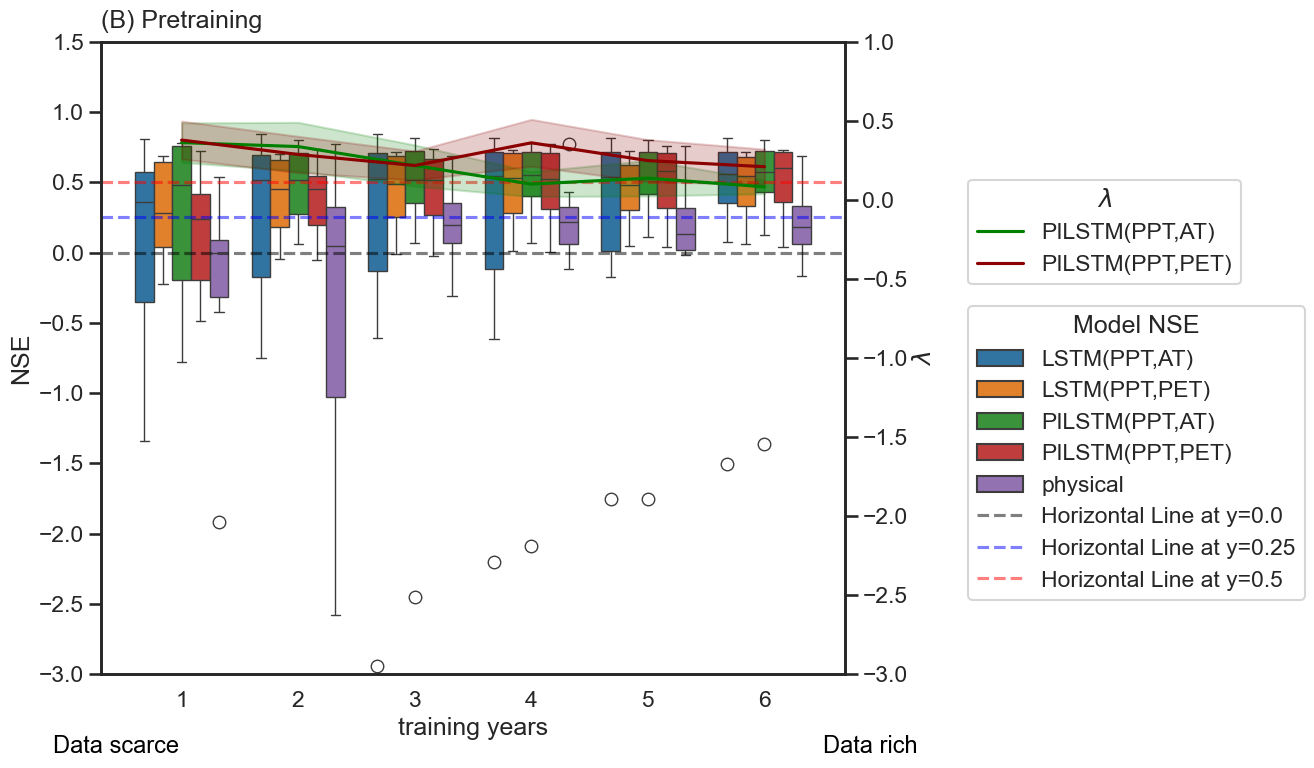

In [32]:
res_df = pd.concat([exp_res_df, phy_res_df], axis=0)
res_df_sub = res_df[(res_df['model']=='PILSTM(PPT,PET)' )|(res_df['model']=='PILSTM(PPT,AT)' )]
res_df_sub['training_years'] = res_df_sub['training_years'] - 1

# start plotting
sns.set_context("talk", font_scale = 1)
fig, ax1 = plt.subplots(figsize=(14,8))
ax2 = ax1.twinx()

######## 1st plot
sns.boxplot(data=res_df, x="training_years", y="NSE", hue="model", ax=ax1)#,errorbar=None)
ax1.set_ylim(-3,1.5)

######## 2nd plot
sns.lineplot(data=res_df_sub, x='training_years', y='lambda', hue='model',
             ax=ax2, errorbar=('se'), 
             palette={'PILSTM(PPT,AT)': 'green', 'PILSTM(PPT,PET)': 'darkred'})

ax2.set_ylim(-3,1)

# legends
ax1.axhline(y=0, color='black', alpha=0.5, linestyle='--', label='Horizontal Line at y=0.0')
ax1.axhline(y=0.25, color='blue', alpha=0.5, linestyle='--', label='Horizontal Line at y=0.25')
ax1.axhline(y=0.5, color='red', alpha=0.5, linestyle='--', label='Horizontal Line at y=0.5')
legend1 = ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 0.6))

legend1.set_title('Model NSE')

legend2 = ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.8))
legend2.set_title(r'$\lambda$')

ax1.set_xlabel('training years')
ax2.set_ylabel(r'$\lambda$')

plt.title('(B) Pretraining', loc='left', pad=10)

ax2.text(-1.1, -3.5, 'Data scarce', fontsize=17, color='black')
ax2.text(5.5, -3.5, 'Data rich', fontsize=17, color='black')

plt.tight_layout()
plt.savefig('figures/Figure 5B.data_scarce_pretrain_long_y.jpg', dpi=200)

# Climate change scenario analysis

## Physical model performance 

In [166]:
watersheds = ['DryCreek','HJAndrews','HarvardForest','HubbardBrook',
              'JornadaBasin','Kellogg','KonzaPrairie','Sevilleta']
dir_path = '/Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment'

res = []
for watershed in watersheds[:]:
    print('\n', watershed)
    watershed_lower_case = watershed.lower()
    
    for dry_wet_index in range(1,8):
        yaml_file_path = f"{dir_path}/LSTM_AT_PPT/configs/climatechange/finetune_{watershed_lower_case}_lstm_at_ppt_climatechange_{dry_wet_index}.yml"
        print('yaml_file_path is', yaml_file_path)

        res_d = physical_model_performance_base_experiment(watershed = watershed,
                                                           yaml_file_path = yaml_file_path,
                                                           data_path = '/Users/angelikazhang/Desktop/PILSTM/chosen/'
                                                          )
        res_d['dry_wet_index'] = dry_wet_index
        res.append(res_d)
    
phy_res_df = pd.DataFrame(res)


 DryCreek
yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/configs/climatechange/finetune_drycreek_lstm_at_ppt_climatechange_1.yml
train_start_dates are [datetime.datetime(2006, 10, 1, 0, 0)]
train_end_dates are [datetime.datetime(2012, 9, 30, 0, 0)]
par_file_name is DryCreek_QSmodel_parameters_searching_2006-10-01_2012-09-30.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-3.690789930518239, -1.6969452835164736], 'c2': [-1.2527739013477874, 2.1314485513585972], 'c3': [-0.628539887166357, 1.0998933693024273], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is DryCreek_QSmodel_parameters_searching_2006-10-01_2012-09-30.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-3.6591405355656828, -3.605393125660433), 'c2': (0.556125549329

yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/configs/climatechange/finetune_drycreek_lstm_at_ppt_climatechange_7.yml
train_start_dates are [datetime.datetime(2006, 10, 1, 0, 0), datetime.datetime(2015, 10, 1, 0, 0)]
train_end_dates are [datetime.datetime(2010, 9, 30, 0, 0), datetime.datetime(2017, 9, 30, 0, 0)]
par_file_name is DryCreek_QSmodel_parameters_searching_2006-10-01_2010-09-30_2015-10-01_2017-09-30.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-3.5135896031502565, -1.7859482013303243], 'c2': [-1.2981578742687252, 1.2850691713001137], 'c3': [-2.799901022082354, 2.006109191389468], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is DryCreek_QSmodel_parameters_searching_2006-10-01_2010-09-30_2015-10-01_2017-09-30.csv

Read former calibration results
Read 150

yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/configs/climatechange/finetune_hjandrews_lstm_at_ppt_climatechange_6.yml
train_start_dates are [datetime.datetime(2006, 10, 1, 0, 0)]
train_end_dates are [datetime.datetime(2012, 9, 30, 0, 0)]
par_file_name is HJAndrews_QSmodel_parameters_searching_2006-10-01_2012-09-30.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-6.039060115220801, -0.872623282184426], 'c2': [-0.9535107930331496, 2.626718421806478], 'c3': [-0.29644783819388437, 0.27958092347948554], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is HJAndrews_QSmodel_parameters_searching_2006-10-01_2012-09-30.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-4.574617650773094, -4.4923238229267906), 'c2': (1.5528534066663557, 1

yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/configs/climatechange/finetune_harvardforest_lstm_at_ppt_climatechange_5.yml
train_start_dates are [datetime.datetime(2009, 1, 1, 0, 0), datetime.datetime(2015, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2009, 12, 31, 0, 0), datetime.datetime(2019, 12, 31, 0, 0)]
par_file_name is HarvardForest_QSmodel_parameters_searching_2009-01-01_2009-12-31_2015-01-01_2019-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-4.8041681436544525, -3.07493127190969], 'c2': [1.5320109505335329, 3.289378553361473], 'c3': [-0.6068732863713984, -0.1673476040894679], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is HarvardForest_QSmodel_parameters_searching_2009-01-01_2009-12-31_2015-01-01_2019-12-31.csv

Read former calibration re

yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/configs/climatechange/finetune_hubbardbrook_lstm_at_ppt_climatechange_4.yml
train_start_dates are [datetime.datetime(1999, 1, 1, 0, 0), datetime.datetime(2008, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2002, 12, 31, 0, 0), datetime.datetime(2009, 12, 31, 0, 0)]
par_file_name is HubbardBrook_QSmodel_parameters_searching_1999-01-01_2002-12-31_2008-01-01_2009-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-2.8578314390898654, -2.0525318504589447], 'c2': [0.5573490633081866, 2.0358867864731804], 'c3': [-0.45999613242023896, 0.013479177749093657], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is HubbardBrook_QSmodel_parameters_searching_1999-01-01_2002-12-31_2008-01-01_2009-12-31.csv

Read former calibration 

yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/configs/climatechange/finetune_jornadabasin_lstm_at_ppt_climatechange_3.yml
train_start_dates are [datetime.datetime(2001, 1, 1, 0, 0), datetime.datetime(2007, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2001, 12, 31, 0, 0), datetime.datetime(2011, 12, 31, 0, 0)]
par_file_name is JornadaBasin_QSmodel_parameters_searching_2001-01-01_2001-12-31_2007-01-01_2011-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-5.863449660691897, -1.986673139007269], 'c2': [-3.259009617563464, -1.4129849926504692], 'c3': [-0.4195767611765383, -0.2134033809879929], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is JornadaBasin_QSmodel_parameters_searching_2001-01-01_2001-12-31_2007-01-01_2011-12-31.csv

Read former calibration res

yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/configs/climatechange/finetune_kellogg_lstm_at_ppt_climatechange_2.yml
train_start_dates are [datetime.datetime(2008, 1, 1, 0, 0), datetime.datetime(2018, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2012, 12, 31, 0, 0), datetime.datetime(2018, 12, 31, 0, 0)]
par_file_name is Kellogg_QSmodel_parameters_searching_2008-01-01_2012-12-31_2018-01-01_2018-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-3.427790153242625, -2.4311794196826058], 'c2': [0.0737010696131476, 1.8777510333200884], 'c3': [-0.6271602114713878, 0.2682319592449818], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is Kellogg_QSmodel_parameters_searching_2008-01-01_2012-12-31_2018-01-01_2018-12-31.csv

Read former calibration results
Read 15001 


 KonzaPrairie
yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/configs/climatechange/finetune_konzaprairie_lstm_at_ppt_climatechange_1.yml
train_start_dates are [datetime.datetime(2009, 10, 1, 0, 0)]
train_end_dates are [datetime.datetime(2015, 9, 30, 0, 0)]
par_file_name is KonzaPrairie_QSmodel_parameters_searching_2009-10-01_2015-09-30.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-2.527009439307652, -2.0936120120931347], 'c2': [0.4626000703034162, 1.5020188486481882], 'c3': [-0.13694961325071986, 0.3450536396122148], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is KonzaPrairie_QSmodel_parameters_searching_2009-10-01_2015-09-30.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-2.3392683249728448, -2.22452563316968), 'c2':

/Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/neuralhydrology/datautils/QS_physical_model.py:480: RuntimeWarning: overflow encountered in exp
  Q_curr = np.exp( np.log(Q_former) + delta)


yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/configs/climatechange/finetune_konzaprairie_lstm_at_ppt_climatechange_7.yml
train_start_dates are [datetime.datetime(2014, 10, 1, 0, 0)]
train_end_dates are [datetime.datetime(2020, 9, 30, 0, 0)]
par_file_name is KonzaPrairie_QSmodel_parameters_searching_2014-10-01_2020-09-30.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-3.3620640420828756, -2.2460785777547385], 'c2': [0.32453544520728794, 1.9191177072113939], 'c3': [-0.23153227259770665, 0.30296531697120094], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is KonzaPrairie_QSmodel_parameters_searching_2014-10-01_2020-09-30.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-2.389478050272412, -2.2460785777547385), 'c2': (0.3922420

/Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/neuralhydrology/datautils/QS_physical_model.py:480: RuntimeWarning: overflow encountered in exp
  Q_curr = np.exp( np.log(Q_former) + delta)



 Sevilleta
yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/configs/climatechange/finetune_sevilleta_lstm_at_ppt_climatechange_1.yml
train_start_dates are [datetime.datetime(2009, 1, 1, 0, 0), datetime.datetime(2018, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2012, 12, 31, 0, 0), datetime.datetime(2019, 12, 31, 0, 0)]
par_file_name is Sevilleta_QSmodel_parameters_searching_2009-01-01_2012-12-31_2018-01-01_2019-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-12.21613477275757, 7.8378108625332805], 'c2': [-6.826568614655902, 4.414193524747371], 'c3': [-0.9667472776455684, 0.5861766215156304], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is Sevilleta_QSmodel_parameters_searching_2009-01-01_2012-12-31_2018-01-01_2019-12-31.csv

Read former calibration res

yaml_file_path is /Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment/LSTM_AT_PPT/configs/climatechange/finetune_sevilleta_lstm_at_ppt_climatechange_7.yml
train_start_dates are [datetime.datetime(2009, 1, 1, 0, 0)]
train_end_dates are [datetime.datetime(2014, 12, 31, 0, 0)]
par_file_name is Sevilleta_QSmodel_parameters_searching_2009-01-01_2014-12-31.csv

Initiate the physical model to prepare for the training of the PILSTM model
Calculate PEQ statistics
Prepare the data for parameters calibration
Estimate parameter ranges
Initial parameter ranges are {'c1': [-2.293354970284998, 0.42926912461074906], 'c2': [-1.5042182863541764, 0.6545858705977634], 'c3': [-0.2491494981419906, 0.10323741410262753], 'runoff_coef': [0.1, 0.9]}
self.par_file_name is Sevilleta_QSmodel_parameters_searching_2009-01-01_2014-12-31.csv

Read former calibration results
Read 15001 records
Current parameter range is {'c1': (-1.4177202896560164, -1.302321315552651), 'c2': (-0.640478758426799, 

In [167]:
phy_res_df = phy_res_df[['dry_wet_index', 'watershed', 'NSE']]
phy_res_df['model'] = 'physical'
phy_res_df['lambda'] = None
print(phy_res_df.shape)
phy_res_df.head()

(56, 5)


dry_wet_index watershed   NSE     model lambda
0              1  DryCreek  0.69  physical   None
1              2  DryCreek  0.64  physical   None
2              3  DryCreek  0.18  physical   None
3              4  DryCreek -0.15  physical   None
4              5  DryCreek  0.63  physical   None

## No pretraining

### Ensemble run

In [168]:
dir_path = '/Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment'
scenario = 'climatechange_nopretrain'

exps = [ 'LSTM_AT_PPT', 'LSTM_ET_PPT', 'PILSTM_PPT_AT_1out', 'PILSTM_PPT_ET_1out'] # ,

exp_name_d = {'LSTM_AT_PPT':'LSTM(PPT,AT)',
              'LSTM_ET_PPT':'LSTM(PPT,PET)',
              'PILSTM_PPT_AT_1out': 'PILSTM(PPT,AT)',
              'PILSTM_PPT_ET_1out': 'PILSTM(PPT,PET)'}

res_df = pd.DataFrame()

for watershed in watersheds[:]:
    watershed_lower = watershed.lower()
    print(watershed)
    
    for exp in exps:
        #print(exp)
        if 'PILSTM' in exp:
            #Q_col = 'Qpilstm(mm/d)'
            eval_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}_new/{exp}_{scenario}_new_{watershed_lower}_eval_result.csv',index_col=0)
            eval_df = eval_df[['dry_wet_index','watershed', f'NSE', 'lambda', 'seed','optimal_epoch']]

            valid_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}_new/{exp}_{scenario}_new_{watershed_lower}_validation_result.csv',index_col=0)

        else:
            Q_col = 'QObs(mm/d)'
            eval_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_eval_result.csv',index_col=0)
            eval_df = eval_df[['dry_wet_index', 'watershed', f'{Q_col}_NSE', 'lambda', 'seed','optimal_epoch']]
        
            valid_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_validation_result.csv',index_col=0)

        # find the optimal epoch and lambda for each dry_wet_index, each seed
        valid_df_optimal = valid_df.loc[valid_df.groupby(['watershed','dry_wet_index', 'seed'])['NSE'].idxmax()][['watershed','dry_wet_index','seed', 'lambda', 'epoch']]
        
        eval_df_optimal = pd.merge(eval_df, valid_df_optimal, on=['watershed','dry_wet_index','seed', 'lambda'], how='inner')
        
        eval_df_optimal.rename(columns = {f'{Q_col}_NSE':'NSE'},inplace = True)
        eval_df_optimal = eval_df_optimal.groupby(['dry_wet_index']).mean(numeric_only=True).reset_index()
        
        eval_df_optimal['watershed'] = watershed
        eval_df_optimal['model'] = exp_name_d[exp]

        res_df = pd.concat([res_df, eval_df_optimal], ignore_index=True)

exp_res_df = copy.deepcopy(res_df)
exp_res_df                             

DryCreek
HJAndrews
HarvardForest
HubbardBrook
JornadaBasin
Kellogg
KonzaPrairie
Sevilleta


dry_wet_index       NSE  lambda   seed  optimal_epoch  epoch  watershed  \
0                1  0.184910    0.00  569.9           14.1   14.1   DryCreek   
1                2  0.398654    0.00  569.9           14.5   14.5   DryCreek   
2                3  0.588156    0.00  569.9           12.6   12.6   DryCreek   
3                4  0.517981    0.00  569.9            5.8    5.8   DryCreek   
4                5  0.518041    0.00  569.9            6.5    6.5   DryCreek   
..             ...       ...     ...    ...            ...    ...        ...   
219              3  0.044472    0.16  569.9           15.1   15.1  Sevilleta   
220              4  0.005948    0.16  569.9           25.0   25.0  Sevilleta   
221              5  0.035947    0.20  569.9           19.8   19.8  Sevilleta   
222              6  0.037434    0.14  569.9           15.7   15.7  Sevilleta   
223              7  0.024292    0.19  569.9           13.2   13.2  Sevilleta   

               model  
0       LSTM(PPT,AT)  
1       LSTM(PPT,AT)  
2       LSTM(PPT,AT)  
3       LSTM(PPT,AT)  
4       LSTM(PPT,AT)  
..               ...  
219  PILSTM(PPT,PET)  
220  PILSTM(PPT,PET)  
221  PILSTM(PPT,PET)  
222  PILSTM(PPT,PET)  
223  PILSTM(PPT,PET)  

[224 rows x 8 columns]

/var/folders/xj/q38s9lg550sfgkfvnw1gfblr0000gn/T/ipykernel_67659/429384095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df_sub['dry_wet_index'] = res_df_sub['dry_wet_index'] - 1


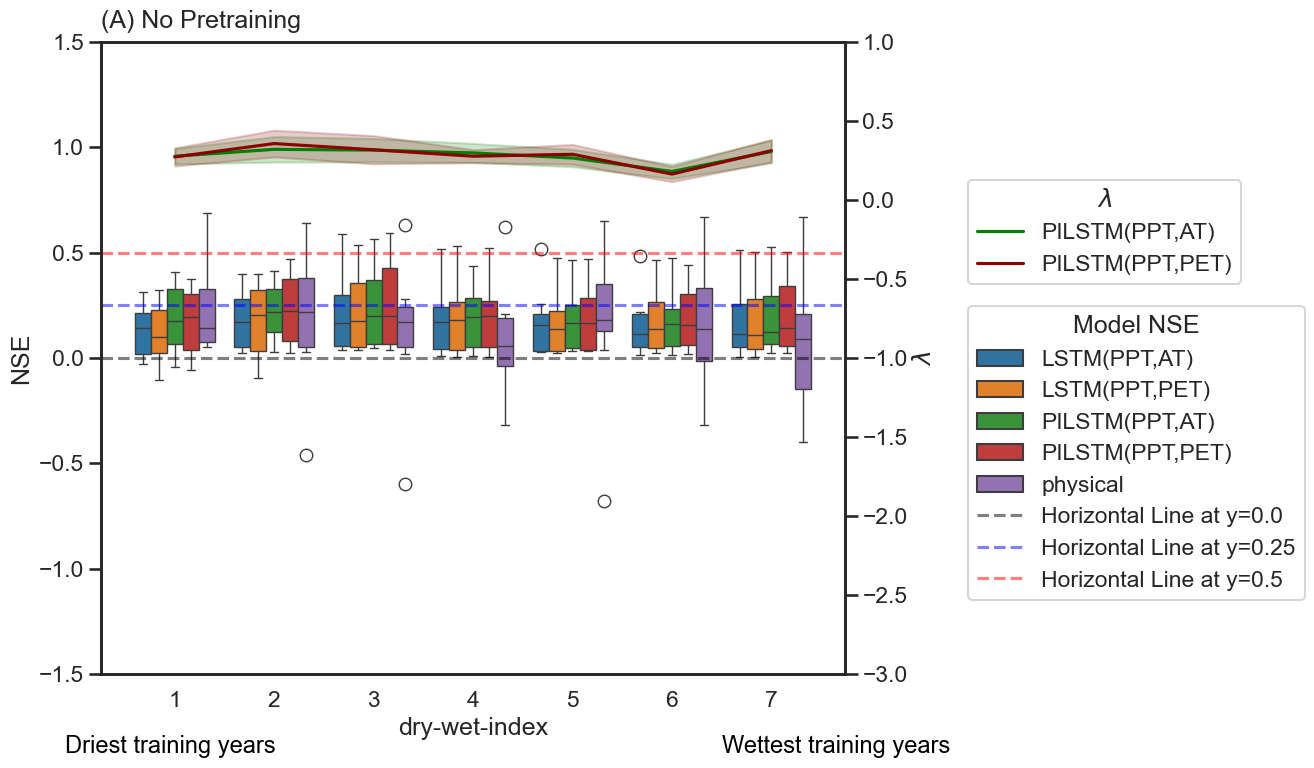

In [169]:
res_df = pd.concat([exp_res_df, phy_res_df], axis=0)
res_df_sub = res_df[(res_df['model']=='PILSTM(PPT,PET)' )|(res_df['model']=='PILSTM(PPT,AT)' )]
res_df_sub['dry_wet_index'] = res_df_sub['dry_wet_index'] - 1

# start plotting
sns.set_context("talk", font_scale = 1)
fig, ax1 = plt.subplots(figsize=(14,8))
ax2 = ax1.twinx()

######## 1st plot
sns.boxplot(data=res_df, x="dry_wet_index", y="NSE", hue="model", ax=ax1)#,errorbar=None)
ax1.set_ylim(-1.5,1.5)

######## 2nd plot
sns.lineplot(data=res_df_sub, x='dry_wet_index', y='lambda', hue='model',
             ax=ax2, errorbar=('se'), 
             palette={'PILSTM(PPT,AT)': 'green', 'PILSTM(PPT,PET)': 'darkred'})

ax2.set_ylim(-3,1)

# legends
ax1.axhline(y=0, color='black', alpha=0.5, linestyle='--', label='Horizontal Line at y=0.0')
ax1.axhline(y=0.25, color='blue', alpha=0.5, linestyle='--', label='Horizontal Line at y=0.25')
ax1.axhline(y=0.5, color='red', alpha=0.5, linestyle='--', label='Horizontal Line at y=0.5')
legend1 = ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 0.6))

legend1.set_title('Model NSE')

legend2 = ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.8))
legend2.set_title(r'$\lambda$')

ax1.set_xlabel('dry-wet-index')

plt.title('(A) No Pretraining', loc='left', pad=10)

ax2.text(-1.1, -3.5, 'Driest training years', fontsize=17, color='black')
ax2.text(5.5, -3.5, 'Wettest training years', fontsize=17, color='black')
ax2.set_ylabel(r'$\lambda$')

plt.tight_layout()
plt.savefig('figures/Figure 4A.climate_change_NSE_nopretrain_ensemble_new.jpg', dpi=200)

In [171]:
res_df_sub['lambda'].mean()

0.28184807256235833

In [172]:
res_df_sub['lambda'].median()

0.21214285714285713

## Pretraining

### Ensemble run

In [173]:
dir_path = '/Users/angelikazhang/Desktop/PILSTM/neuralhydrology-master/base_experiment'
scenario = 'climatechange_ensemble'

exps = [ 'LSTM_AT_PPT', 'LSTM_ET_PPT',  'PILSTM_PPT_ET_1out', 'PILSTM_PPT_AT_1out']

exp_name_d = {'LSTM_AT_PPT':'LSTM(PPT,AT)',
              'LSTM_ET_PPT':'LSTM(PPT,PET)',
              'PILSTM_PPT_AT_1out': 'PILSTM(PPT,AT)',
              'PILSTM_PPT_ET_1out': 'PILSTM(PPT,PET)'}

res_df = pd.DataFrame()

for watershed in watersheds[:]:
    watershed_lower = watershed.lower()
    
    for exp in exps:
        if 'PILSTM' in exp:
            #Q_col = 'Qpilstm(mm/d)'
            eval_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}_new/{exp}_{scenario}_new_{watershed_lower}_eval_result.csv',index_col=0)
            eval_df = eval_df[['dry_wet_index', 'watershed', 'NSE', 'lambda', 'seed','optimal_epoch']]
            valid_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}_new/{exp}_{scenario}_new_{watershed_lower}_validation_result.csv',index_col=0)

        else:
            Q_col = 'QObs(mm/d)'
            eval_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_eval_result.csv',index_col=0)
            eval_df = eval_df[['dry_wet_index', 'watershed', f'{Q_col}_NSE', 'lambda', 'seed','optimal_epoch']]
            valid_df = pd.read_csv(f'{dir_path}/{exp}/results/{scenario}/{exp}_{scenario}_{watershed_lower}_validation_result.csv',index_col=0)

        # find the optimal epoch and lambda for each dry_wet_index, each seed
        valid_df_optimal = valid_df.loc[valid_df.groupby(['watershed','dry_wet_index', 'seed'])['NSE'].idxmax()][['watershed','dry_wet_index','seed', 'lambda', 'epoch']]
        
        eval_df_optimal = pd.merge(eval_df, valid_df_optimal, on=['watershed','dry_wet_index','seed', 'lambda'], how='inner')
        
        eval_df_optimal.rename(columns = {f'{Q_col}_NSE':'NSE'},inplace = True)
        eval_df_optimal = eval_df_optimal.groupby(['dry_wet_index']).mean(numeric_only=True).reset_index()
        
        eval_df_optimal['watershed'] = watershed
        eval_df_optimal['model'] = exp_name_d[exp]

        res_df = pd.concat([res_df, eval_df_optimal], ignore_index=True)
        

exp_res_df = copy.deepcopy(res_df)
exp_res_df = exp_res_df.sort_values(by='model')
exp_res_df   


dry_wet_index       NSE  lambda   seed  optimal_epoch  epoch  \
0                1  0.723225    0.00  569.9            2.1    2.1   
34               7  0.803438    0.00  569.9            7.8    7.8   
145              6  0.510373    0.00  569.9           13.8   13.8   
146              7  0.447412    0.00  569.9           29.7   29.7   
174              7  0.575150    0.00  569.9           21.1   21.1   
..             ...       ...     ...    ...            ...    ...   
187              6  0.519731    0.00  569.9           25.6   25.6   
188              7  0.553238    0.00  569.9           27.9   27.9   
159              6 -0.134056    0.92  569.9           26.9   26.9   
75               6  0.750820    0.00  569.9           30.0   30.0   
70               1  0.632699    0.00  569.9           29.7   29.7   

         watershed            model  
0         DryCreek     LSTM(PPT,AT)  
34       HJAndrews     LSTM(PPT,AT)  
145        Kellogg     LSTM(PPT,AT)  
146        Kellogg     LSTM(PPT,AT)  
174   KonzaPrairie     LSTM(PPT,AT)  
..             ...              ...  
187   KonzaPrairie  PILSTM(PPT,PET)  
188   KonzaPrairie  PILSTM(PPT,PET)  
159        Kellogg  PILSTM(PPT,PET)  
75   HarvardForest  PILSTM(PPT,PET)  
70   HarvardForest  PILSTM(PPT,PET)  

[224 rows x 8 columns]

In [139]:
res_df = pd.concat([exp_res_df, phy_res_df], axis=0)
res_df_sub = res_df[(res_df['model']=='PILSTM(PPT,PET)' )|(res_df['model']=='PILSTM(PPT,AT)' )]
res_df_sub['dry_wet_index'] = res_df_sub['dry_wet_index'] - 1

/var/folders/xj/q38s9lg550sfgkfvnw1gfblr0000gn/T/ipykernel_67659/3354132935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df_sub['dry_wet_index'] = res_df_sub['dry_wet_index'] - 1


In [140]:
res_df[res_df['model']=='PILSTM(PPT,AT)'].sort_values(by='NSE')

dry_wet_index       NSE  lambda   seed  optimal_epoch  epoch  \
161              1 -2.131211    0.00  569.9           29.8   29.8   
139              7 -2.078492    0.12  569.9           25.5   25.5   
165              5 -1.654109    0.07  569.9           30.0   30.0   
163              3 -1.565650    0.00  569.9           28.8   28.8   
133              1 -1.359969    0.36  569.9           29.8   29.8   
137              5 -0.899785    0.00  569.9           19.8   19.8   
135              3 -0.759616    1.00  569.9           30.0   30.0   
136              4 -0.587010    1.00  569.9           29.5   29.5   
138              6 -0.575679    0.04  569.9           22.1   22.1   
24               4 -0.424466    0.00  569.9            6.1    6.1   
134              2 -0.265125    0.10  569.9           29.3   29.3   
217              1 -0.187339    0.00  569.9           19.3   19.3   
25               5 -0.145641    0.00  569.9           11.6   11.6   
26               6 -0.130935    0.10  569.9           12.2   12.2   
219              3  0.067677    0.00  569.9            2.2    2.2   
220              4  0.074154    0.00  569.9            5.0    5.0   
221              5  0.106649    0.64  569.9           24.5   24.5   
222              6  0.111679    0.84  569.9           22.6   22.6   
191              3  0.118886    0.63  569.9           30.0   30.0   
218              2  0.123039    0.04  569.9           15.8   15.8   
223              7  0.126326    0.00  569.9           28.6   28.6   
193              5  0.141648    0.58  569.9           30.0   30.0   
192              4  0.160737    0.11  569.9            2.8    2.8   
164              4  0.321242    0.72  569.9           30.0   30.0   
162              2  0.325511    0.96  569.9           30.0   30.0   
190              2  0.417992    0.37  569.9           20.7   20.7   
166              6  0.484499    0.58  569.9           30.0   30.0   
189              1  0.497316    0.17  569.9           11.5   11.5   
22               2  0.502785    0.95  569.9           29.7   29.7   
167              7  0.534915    0.14  569.9           21.8   21.8   
107              3  0.545130    0.00  569.9           30.0   30.0   
111              7  0.577607    0.00  569.9           30.0   30.0   
195              7  0.601408    0.00  569.9           27.2   27.2   
194              6  0.611185    0.00  569.9           29.1   29.1   
105              1  0.656571    0.00  569.9           29.2   29.2   
110              6  0.658799    0.00  569.9           29.9   29.9   
108              4  0.665157    0.02  569.9           29.0   29.0   
21               1  0.665286    0.99  569.9           24.3   24.3   
106              2  0.666846    0.00  569.9           28.5   28.5   
109              5  0.681149    0.01  569.9           29.0   29.0   
27               7  0.701636    0.09  569.9            3.6    3.6   
52               4  0.709128    0.91  569.9            1.5    1.5   
23               3  0.735001    0.00  569.9           14.8   14.8   
55               7  0.762404    0.52  569.9           28.4   28.4   
81               5  0.770365    0.19  569.9            8.9    8.9   
80               4  0.770369    0.00  569.9           20.0   20.0   
78               2  0.773501    0.00  569.9           17.7   17.7   
82               6  0.780410    0.00  569.9           23.9   23.9   
83               7  0.787439    0.00  569.9           29.7   29.7   
77               1  0.789995    0.00  569.9           24.0   24.0   
54               6  0.791384    0.50  569.9           23.8   23.8   
51               3  0.799773    0.03  569.9           21.6   21.6   
79               3  0.806568    0.00  569.9           22.3   22.3   
53               5  0.825973    0.00  569.9           13.4   13.4   
50               2  0.864952    0.00  569.9           28.5   28.5   
49               1  0.876256    0.00  569.9           29.4   29.4   

         watershed           model  
161        Kellogg  PILSTM(PPT,AT)

In [141]:
res_df[res_df['model']=='PILSTM(PPT,PET)'].sort_values(by='NSE')

dry_wet_index       NSE  lambda   seed  optimal_epoch  epoch  \
126              1 -3.480738    0.03  569.9           29.1   29.1   
158              5 -2.549085    0.04  569.9           17.9   17.9   
132              7 -1.047232    0.50  569.9           29.5   29.5   
130              5 -0.916356    0.11  569.9           29.6   29.6   
127              2 -0.605028    0.72  569.9           29.6   29.6   
131              6 -0.596181    0.68  569.9           29.3   29.3   
128              3 -0.450375    1.00  569.9           29.5   29.5   
129              4 -0.385874    1.00  569.9           29.4   29.4   
157              4 -0.212707    0.95  569.9           29.3   29.3   
210              1 -0.140607    0.06  569.9           23.3   23.3   
159              6 -0.134056    0.92  569.9           26.9   26.9   
212              3  0.002100    0.00  569.9            5.3    5.3   
213              4  0.032534    0.04  569.9           26.2   26.2   
211              2  0.039078    0.03  569.9           19.1   19.1   
214              5  0.104249    0.67  569.9           27.3   27.3   
216              7  0.114828    0.48  569.9           29.3   29.3   
215              6  0.136834    0.52  569.9           29.3   29.3   
184              3  0.212751    0.05  569.9           29.8   29.8   
185              4  0.220436    0.06  569.9           24.6   24.6   
186              5  0.222003    0.00  569.9           29.8   29.8   
182              1  0.245358    0.53  569.9           12.5   12.5   
183              2  0.298085    0.00  569.9            2.5    2.5   
154              1  0.378040    0.14  569.9           29.8   29.8   
156              3  0.382181    0.00  569.9           29.8   29.8   
155              2  0.419966    0.39  569.9           29.7   29.7   
98               1  0.429025    0.00  569.9           30.0   30.0   
100              3  0.463756    0.02  569.9           29.3   29.3   
99               2  0.480731    0.00  569.9           30.0   30.0   
104              7  0.516803    0.00  569.9           30.0   30.0   
187              6  0.519731    0.00  569.9           25.6   25.6   
101              4  0.521872    0.01  569.9           30.0   30.0   
103              6  0.535256    0.00  569.9           30.0   30.0   
188              7  0.553238    0.00  569.9           27.9   27.9   
16               3  0.565020    0.12  569.9           11.1   11.1   
102              5  0.583122    0.02  569.9           30.0   30.0   
73               4  0.589007    0.00  569.9           29.3   29.3   
19               6  0.610229    0.19  569.9            4.4    4.4   
71               2  0.631207    0.00  569.9           29.2   29.2   
70               1  0.632699    0.00  569.9           29.7   29.7   
15               2  0.637304    0.27  569.9           10.8   10.8   
18               5  0.639620    0.06  569.9           16.9   16.9   
14               1  0.645671    0.30  569.9           13.4   13.4   
160              7  0.647315    0.25  569.9            9.2    9.2   
72               3  0.666349    0.00  569.9           29.8   29.8   
45               4  0.677660    0.40  569.9            1.0    1.0   
17               4  0.704802    0.32  569.9           14.1   14.1   
48               7  0.708511    0.90  569.9            9.1    9.1   
42               1  0.710400    0.01  569.9            8.3    8.3   
47               6  0.710851    1.00  569.9            1.0    1.0   
76               7  0.712169    0.00  569.9           30.0   30.0   
43               2  0.715478    0.00  569.9           21.8   21.8   
44               3  0.723119    0.49  569.9            6.8    6.8   
20               7  0.731066    0.86  569.9           15.4   15.4   
74               5  0.739478    0.08  569.9           29.0   29.0   
46               5  0.740208    0.06  569.9           18.4   18.4   
75               6  0.750820    0.00  569.9           30.0   30.0   

         watershed            model  
126   JornadaBasin  PILSTM(PPT,PE

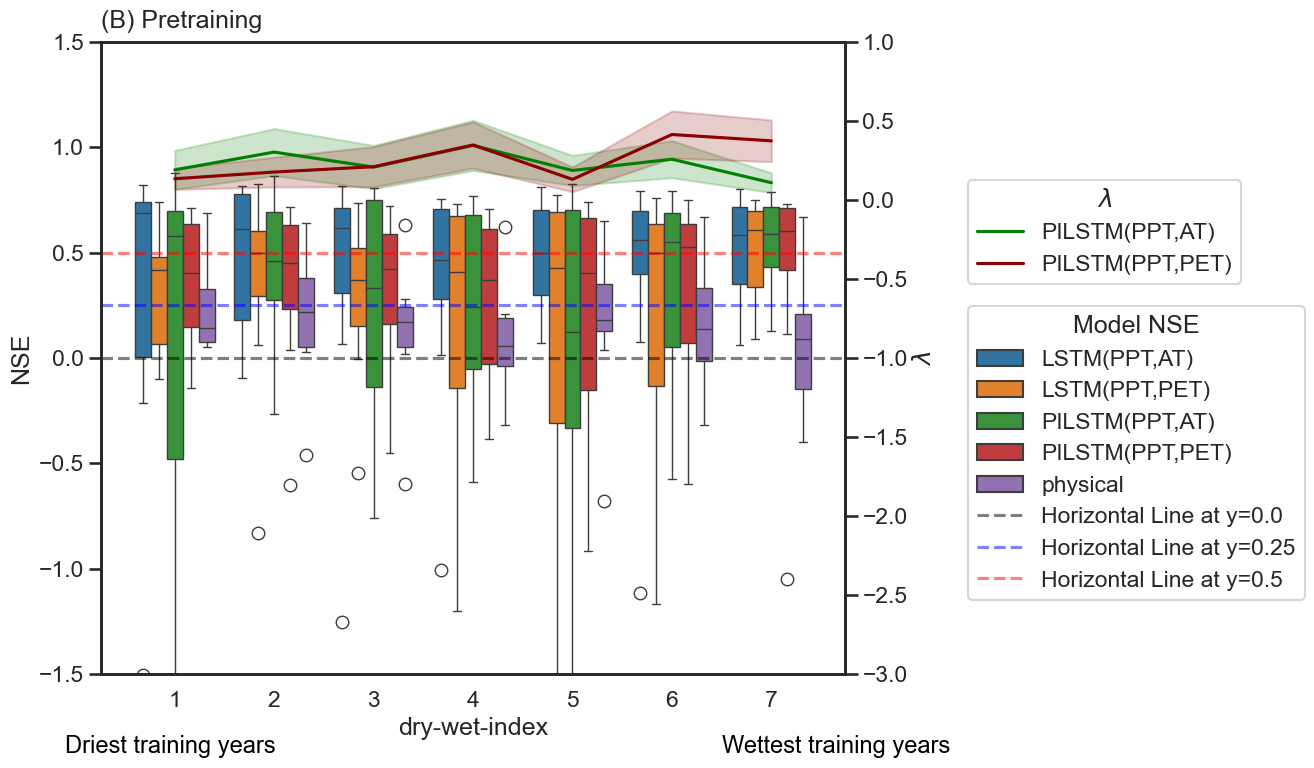

In [142]:
# start plotting
sns.set_context("talk", font_scale = 1)
fig, ax1 = plt.subplots(figsize=(14,8))
ax2 = ax1.twinx()

######## 1st plot
sns.boxplot(data=res_df, x="dry_wet_index", y="NSE", hue="model", ax=ax1)#,errorbar=None)
ax1.set_ylim(-1.5,1.5)

######## 2nd plot
sns.lineplot(data=res_df_sub, x='dry_wet_index', y='lambda', hue='model',
             ax=ax2, errorbar=('se'), 
             palette={'PILSTM(PPT,AT)': 'green', 'PILSTM(PPT,PET)': 'darkred'})

ax2.set_ylim(-3,1)

# legends
ax1.axhline(y=0, color='black', alpha=0.5, linestyle='--', label='Horizontal Line at y=0.0')
ax1.axhline(y=0.25, color='blue', alpha=0.5, linestyle='--', label='Horizontal Line at y=0.25')
ax1.axhline(y=0.5, color='red', alpha=0.5, linestyle='--', label='Horizontal Line at y=0.5')
legend1 = ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 0.6))

legend1.set_title('Model NSE')

legend2 = ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.8))
legend2.set_title(r'$\lambda$')

ax1.set_xlabel('dry-wet-index')

plt.title('(B) Pretraining', loc='left', pad=10)

ax2.text(-1.1, -3.5, 'Driest training years', fontsize=17, color='black')
ax2.text(5.5, -3.5, 'Wettest training years', fontsize=17, color='black')
ax2.set_ylabel(r'$\lambda$')

plt.tight_layout()
plt.savefig('figures/Figure 4B.climate_change_NSE_pretrain_ensemble_new.jpg', dpi=200)